# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [0]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [0]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'their', 'isn', 'such', 'where', 'this', 'they', 'while', 'about', 'there', 'myself', 'from', 'mightn', 'was', 'between', 'who', 'are', 'only', 'our', 'those', 'through', 'any', 'is', 'a', 'nor', 'mustn', 'shouldn', 'yourself', 'no', 'itself', 'that', 'himself', 'out', 'what', 'my', 'against', 'below', 's', 'for', 'be', 'into', 'few', 'needn', 'you', 'aren', 'when', 'all', 'him', 'but', 've', 'yours', 'being', 'why', 'own', 'up', 'whom', 're', 'and', 'she', 'me', 'of', 'than', 'doesn', 'both', 'same', 'too', 'am', 'how', 'not', 'her', 'd', 'until', 'o', 'your', 'yourselves', 'by', 'other', 'once', 'an', 'just', 'to', 'these', 'don', 'its', 'haven', 'having', 'some', 'shan', 'theirs', 'under', 'we', 'ain', 'it', 'at', 'in', 'y', 'the', 'off', 'herself', 'down', 'because', 'i', 'now', 'themselves', 'each', 'or', 'were', 'if', 'can', 'did', 'm', 'which', 'couldn', 'ourselves', 'hadn', 'has', 'wasn', 'with', 'here', 'further', 'them', 'hasn', 'should', 'ma', 'then', 'he', 'very', 'above',

In [0]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

**Storing the processed data to 'final.sqlite' database.**

In [0]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [3]:
c = conn.cursor()

In [4]:
final = pd.read_sql_query("""SELECT * FROM Reviews;""", conn)
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,35
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,27
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...,15
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...,50
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...,37


In [5]:
## Encoding the labels

# Label encoding the "Score"
label = LabelEncoder()
score_labels = label.fit_transform(final['Score'])
# Adding new column to the dataset that are label - encoded.
final['score_labels'] = score_labels

In [7]:
final.to_csv('complete_raw_df.csv')

In [ ]:
final.head()

In [ ]:
neg = final[final['score_labels'] == 0].reset_index().drop('index', axis = 1)
pos = final[final['score_labels'] == 1].reset_index().drop('index', axis = 1)

In [ ]:
print(neg.shape, pos.shape)

**Sampling the data as operating on complete data is very expensive.**

In [ ]:
np.random.seed(100)
indices = np.random.choice(np.arange(57110),replace=False, size= 5000)
neg = neg.loc[indices]
print("Negative reviews shape:", neg.shape)
indices = np.random.choice(np.arange(307061),replace=False, size = 5000)
pos = pos.loc[indices]
print("Positive reviews shape", pos.shape)
fil_df = pd.concat([neg, pos])

In [ ]:
fil_df.sort_values(by='Time', inplace=True)

In [ ]:
final_df = fil_df.drop('level_0', axis=1)

In [ ]:
final_df.to_csv("final_df.csv", index=False)

In [2]:
final_df = pd.read_csv('final_df.csv', encoding='cp1252')

In [3]:
final_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount,score_labels
0,361319,B00005IX96,AGUF1WPEG4GSM,"""lchang44""",5,8,negative,1055376000,"Almost expired, Sept '03",I returned this due to the very short/brief ex...,b'return due short brief expir date sept would...,14,0
1,193108,B0000DJDJR,A3F6UNXVI9LSMA,"Samuel H. Wheeler ""bigdaddysam""",7,7,positive,1066348800,Best Ice Cream Ever!!!,As a kid this ice cream was a favorite treat. ...,b'kid ice cream favorit treat ive told highest...,24,1
2,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,positive,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",b'noth product bother link top page buy use ch...,16,1
3,434425,B0000CA4TK,A5VIGE8EO86RI,"captmorgan1670 ""captmorgan1670""",4,4,positive,1068422400,&iexcl;Oye - Tremendo caf&eacute; chico !,I live in exile in Denver now - I couldn't sur...,b'live exil denver couldnt surviv without bit ...,16,1
4,333669,B0000UBTYG,A6BS5D5YPF2HW,MT,3,3,positive,1072137600,A Great Chai!!!,I think that this is a great Chai! Far from sw...,b'think great chai far sweet found unsweet exa...,54,1


# Applying Machine Learing Algorithms

**The data frame is the sample from the complete dataset with 5000 data points of positive and negative classes(randomly chosen).
The sampled dataframe contains all four types of word convertions(tf-idf, avg-w2v, tf-idf-w2v and bow) pre-computed the observations are <font color=red>sorted with increasing to time.</font>**

# Supervised Learning

### Logistic regression

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats.distributions import norm

In [5]:
def model_log(train_x, train_y, test_x, test_y, sim_cv=False, grid = 0, random = 0, l1=False, sparse=False):
    if(sim_cv == False and sparse==False):
        print("Logistic regression with out cross - validation(with default <Lambda / C> value)")
        clf = LogisticRegression()
        clf.fit(train_x, train_y)
        pred = clf.predict(test_x)
        print("-"*100)
        print("The confusion matrix is:", confusion_matrix(test_y, pred))
        print("-"*100)
        print("The accuracy of the model is:", accuracy_score(test_y, pred)*100)
        print("-"*100)
        print("The classification report is", print(classification_report(test_y, pred)))
    else:
        print("Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>")
        if(grid == 1):
            
            parameters = [{'C':[10**-i for i in range(-4, 5)]}]
            if(l1==False):
                print("1. Logistic regression with L2 regulrization - Grid Search")
                log = LogisticRegression()
                clf = GridSearchCV(log, parameters, cv=10, scoring= 'accuracy')
                clf.fit(train_x, train_y)
                print("The best parameters are:")
                print(clf.best_params_)
                pred = clf.predict(test_x)
                print("The accuracy of the model is", accuracy_score(test_y, pred))
            if(l1 == True):
                print("1. Logistic regression with L1 regulrization - Grid Search")
                log = LogisticRegression(penalty='l1')
                clf = GridSearchCV(log, parameters, cv=10, scoring='accuracy')
                clf.fit(train_x, train_y)
                print("The best parameters are:")
                print(clf.best_params_)
                pred = clf.predict(test_x)
                print("The accuracy of the model is", accuracy_score(test_y, pred))
        if(random == 1):
            
            parameters = {'C': list(filter(lambda x: x >0, norm.rvs(size=50)))}
            if(l1 == False):
                print("2. Logistic regression with L2 regularization - Random Search")
                log = LogisticRegression()
                clf = RandomizedSearchCV(log, parameters, cv=10, scoring='accuracy')
                clf.fit(train_x, train_y)
                print("The best parameters are:")
                print(clf.best_params_)
                pred = clf.predict(test_x)
                print("The accuracy of the model is", accuracy_score(test_y, pred))
            if(l1 == True):
                print("2. Logistic regression with L1 regularization - Random Search")
                log = LogisticRegression(penalty='l1')
                clf = GridSearchCV(log, parameters, cv=10, scoring='accuracy')
                clf.fit(train_x, train_y)
                print("The best parameters are:")
                print(clf.best_params_)
                pred = clf.predict(test_x)
                print("The accuracy of the model is", accuracy_score(test_y, pred))
        if(sparse == True):
            print("3. Sparsity with increase in <lambda>(i.e, decrease in C)")
            C = [10**-i for i in range(0, 10)]
            sparsity = []
            for i in C:
                clf = LogisticRegression(penalty='l1', C=i)
                clf.fit(train_x, train_y)
                pred = clf.predict(test_x)
                print("The model accuracy is:", accuracy_score(test_y, pred)*100)
                weights = clf.coef_
                sparsity.append(weights)
            print("The sparsity with L1 regularization is", sparsity)

### KNN

In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [5]:
def model_knn(train_x, train_y, test_x, test_y):
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    cv_scores = []
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm= 'brute')
        scores = cross_val_score(knn, train_x, train_y, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.title("KNN")
    plt.show()

    print("the misclassification error for each k value is :{0} \n\n\n".format(np.round(MSE,3)))
    print("Fitting the model with K value {0}".format(optimal_k))
    
    ## Prediction of test data with optimal K value.
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
    knn_optimal.fit(train_x, train_y)

# predict the response
    pred = knn_optimal.predict(test_x)

# evaluate accuracy
    acc = accuracy_score(test_y, pred) * 100
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

    return None

### Naive - Bayes

In [5]:
from sklearn.naive_bayes import MultinomialNB

In [6]:
def model_nb(train_x, train_y, test_x, test_y, sim_cv=False):
    if(sim_cv == False):
        print("Naive bayes with out cross - validation(with default <alpha> value)")
        clf = MultinomialNB()
        clf.fit(train_x, train_y)
        pred = clf.predict(test_x)
        print("-"*100)
        print("The confusion matrix is:", confusion_matrix(test_y, pred))
        print("-"*100)
        print("The accuracy of the model is:", accuracy_score(test_y, pred)*100)
        print("-"*100)
        print("The classification report is", print(classification_report(test_y, pred)))
    else:
        print("Naive bayes with cross - validation(with choice of <alpha> value)")
        myList = list(range(0,50))
        alpha = list(filter(lambda x: x % 2 != 0, myList))

        cv_scores = []
        for k in alpha:
            nb = MultinomialNB(alpha= k)
            scores = cross_val_score(nb, train_x, train_y, cv=10, scoring='accuracy')
            cv_scores.append(scores.mean())

    # changing to misclassification error
        MSE = [1 - x for x in cv_scores]

    # determining best k
        optimal_alpha = alpha[MSE.index(min(MSE))]
        print('\nThe optimal valus of <alpha> is %d.' % optimal_alpha)

    # plot misclassification error vs k 
        plt.plot(alpha, MSE)

        for xy in zip(alpha, np.round(MSE,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

        plt.xlabel('values of alpha')
        plt.ylabel('Misclassification Error')
        plt.title("Naive Bayes")
        plt.show()

        print("the misclassification error for each <alpha> value is :{0} \n\n\n".format(np.round(MSE,3)))
        print("Fitting the model with <alpha> value {0}".format(optimal_alpha))
    
    ## Prediction of test data with optimal K value.
        nb_model = MultinomialNB(alpha= optimal_alpha)

# fitting the model
        nb_model.fit(train_x, train_y)

# predict the response
        pred = nb_model.predict(test_x)

# evaluate accuracy
        acc = accuracy_score(test_y, pred) * 100
        print('\nThe accuracy of the naive bayes classifier for the <alpha> value = %d is %f%%' % (optimal_alpha, acc))
        print("-"*100)
        print("The classification report is", print(classification_report(test_y, pred)))
    return None

### Support vector machines

In [4]:
from sklearn.linear_model import SGDClassifier

**As computing SVM for large data points is computationally expensive, We train with SGDClassifer with "hinge" loss.**

In [31]:
def model_svm(train_x, train_y, test_x, test_y):
    # C values in linear SVM, as C increases we will over-fit to the data and as C decreases we will Under-fit to the data.
    C = [10 ** x for x in range(-3,5)]
    
    cv_scores = []
    for i in C:
        knn = SGDClassifier(loss='hinge', penalty='l2', alpha=i)
        scores = cross_val_score(knn, train_x, train_y, cv=10, scoring='accuracy', n_jobs=1)
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_C = C[MSE.index(min(MSE))]
    print('\nThe optimal C is %d.' % optimal_C)

    # plot misclassification error vs k 
    plt.plot(C, MSE)

    for xy in zip(C, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Values of C')
    plt.ylabel('Misclassification Error')
    plt.title("Support Vector Machines")
    plt.show()

    print("the misclassification error for each C value is :{0} \n\n\n".format(np.round(MSE,3)))
    print("Fitting the model with C value {0}".format(optimal_C))
    
    ## Prediction of test data with optimal K value.
    svm_optimal = SGDClassifier(loss='hinge', penalty='l2', alpha=optimal_C)

# fitting the model
    svm_optimal.fit(train_x, train_y)

# predict the response
    pred = svm_optimal.predict(test_x)

# evaluate accuracy
    acc = accuracy_score(test_y, pred) * 100
    print('\nThe accuracy of the Support Vector Machine classifier for C = %d is %f%%' % (optimal_C, acc))

    return None

### Decision - Tree

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
def model_dt(train_x, train_y, test_x, test_y, sim_cv=False):
    
    if(sim_cv == False):
        print("Decision tree with default depth")
        clf = DecisionTreeClassifier()
        clf.fit(train_x, train_y)
        pred = clf.predict(test_x)
        print("-"*100)
        print("The confusion matrix is:", confusion_matrix(test_y, pred))
        print("-"*100)
        print("The accuracy of the model is:", accuracy_score(test_y, pred)*100)
        print("-"*100)
        print("The classification report is", print(classification_report(test_y, pred)))
    else:
        print("Decision tree with 10 fold cross - validation(with choice of <depth> value)")
        myList = list(range(0,50))
        depth = list(filter(lambda x: x % 2 != 0, myList))

        cv_scores = []
        for k in depth:
            nb = DecisionTreeClassifier(max_depth= k)
            scores = cross_val_score(nb, train_x, train_y, cv=10, scoring='accuracy')
            cv_scores.append(scores.mean())

    # changing to misclassification error
        MSE = [1 - x for x in cv_scores]

    # determining best k
        optimal_depth = depth[MSE.index(min(MSE))]
        print('\nThe optimal valus of <depth> is %d.' % optimal_depth)

    # plot misclassification error vs k 
        plt.plot(depth, MSE)

        for xy in zip(depth, np.round(MSE,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

        plt.xlabel('values of max_depth')
        plt.ylabel('Misclassification Error')
        plt.title("Decision Tree")
        plt.show()

        print("the misclassification error for each <depth> value is :{0} \n\n\n".format(np.round(MSE,3)))
        print("Fitting the model with <depth> value {0}".format(optimal_depth))
    
    ## Prediction of test data with optimal K value.
        dt_model = DecisionTreeClassifier(max_depth= optimal_depth)

# fitting the model
        dt_model.fit(train_x, train_y)

# predict the response
        pred = dt_model.predict(test_x)

# evaluate accuracy
        acc = accuracy_score(test_y, pred) * 100
        print('\nThe accuracy of the Decision Tree classifier for the <depth> value = %d is %f%%' % (optimal_depth, acc))
    return None

### Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
def random_forest(train_x, train_y, test_x, test_y):
    
    n_estimators = [i for i in range(50, 500, 50)]
    cv_scores = []
    
    for trees in n_estimators:
        ran_model = RandomForestClassifier(n_jobs=-1)
        scores = cross_val_score(ran_model, train_x, train_y, cv=10, scoring='accuracy',n_jobs=-1)
        cv_scores.append(scores.mean())
    
    MSE = [1 - x for x in cv_scores]
    optimal_est = n_estimators[MSE.index(min(MSE))]
    print('\nThe optimal number of estimators are %d.' % optimal_est)
    
    
    plt.plot(n_estimators, MSE)

    for xy in zip(n_estimators, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of estimators')
    plt.ylabel('Misclassification Error')
    plt.title("Random Forest")
    plt.show()
    
    ran_optimal = RandomForestClassifier(n_estimators=optimal_est, n_jobs=-1)

# fitting the model
    ran_optimal.fit(train_x, train_y)

# predict the response
    pred = ran_optimal.predict(test_x)

# evaluate accuracy
    acc = accuracy_score(test_y, pred) * 100
    print('\nThe accuracy of the RandomForest classifier for n_estimators = %d is %f%%' % (optimal_est, acc))
    
    return

**Get the labels of the dataset.**

In [6]:
## Index at which the data is to be sliced.
index = round((10000 / 100) * 70)
train_y = df['score_labels'].values[:index]
test_y = df['score_labels'].values[index:]

**Sample the data**

In [8]:
def sample_data(vectors, dfra, amount):
    points = 10000 / amount
    index = np.arange(0, 10000, points, dtype=int)
    fil_df = dfra.loc[index]
    fil_vec = vectors[index]
    return fil_df, fil_vec

## BOW

In [14]:
## Computing binary BOW.
count_vect = CountVectorizer() 
final_counts = count_vect.fit_transform(final_df['Text'].values)
final_counts = final_counts.toarray()

In [15]:
np.save('final_bow.npy',final_counts)

In [8]:
bow = np.load('final_bow.npy')

In [9]:
## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index)
train_x = bow[:index]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = bow[index:]

print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

The index at which the data to be splitted: 7000
The train_x shape is: (7000, 21326) train_y shape is (7000,)
The test_x shape is: (3000, 21326) test_y shape is (3000,)


**Logistic regression**

In [21]:
# Model with "grid search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, grid=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L2 regulrization - Grid Search
The best parameters are:
{'C': 0.1}
The accuracy of the model is 0.871666666667


In [10]:
# Model with "random search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, random=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L2 regularization - Random Search
The best parameters are:
{'C': 0.15160493325864086}
The accuracy of the model is 0.875333333333


In [23]:
# Model with "grid search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,grid=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L1 regulrization - Grid Search
The best parameters are:
{'C': 1}
The accuracy of the model is 0.864333333333


In [24]:
# Model with "random search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,random=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L1 regularization - Random Search
The best parameters are:
{'C': 0.40329844074669247}
The accuracy of the model is 0.867666666667


In [25]:
# Sparsity calculation with increase in the value of lambda.
model_log(train_x, train_y, test_x, test_y, sparse=True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
3. Sparsity with increase in <lambda>(i.e, decrease in C)
The model accuracy is: 86.4333333333
The model accuracy is: 85.0666666667
The model accuracy is: 72.3333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The sparsity with L1 regularization is [array([[-0.21613166,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]), array([[-0.18288898,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ..

**KNN**


The optimal number of neighbors is 17.


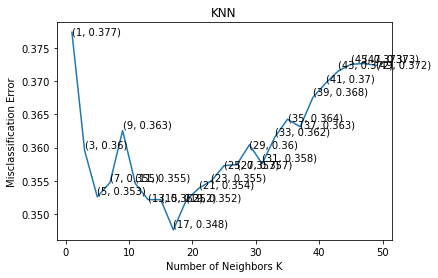

the misclassification error for each k value is :[ 0.377  0.36   0.353  0.355  0.363  0.355  0.352  0.352  0.348  0.352
  0.354  0.355  0.357  0.357  0.36   0.358  0.362  0.364  0.363  0.368
  0.37   0.372  0.373  0.373  0.372] 



Fitting the model with K value 17

The accuracy of the knn classifier for k = 17 is 61.133333%


In [12]:
model_knn(train_x, train_y, test_x, test_y)

**Naive Bayes**

In [35]:
## Fitting the model with out cross - validataion
model_nb(train_x, train_y, test_x, test_y, sim_cv=False)

Naive bayes with out cross - validation(with default <alpha> value)
----------------------------------------------------------------------------------------------------
The confusion matrix is: [[1389  232]
 [ 189 1190]]
----------------------------------------------------------------------------------------------------
The accuracy of the model is: 85.9666666667
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.88      0.86      0.87      1621
          1       0.84      0.86      0.85      1379

avg / total       0.86      0.86      0.86      3000

The classification report is None


Naive bayes with cross - validation(with choice of <alpha> value)

The optimal valus of <alpha> is 3.


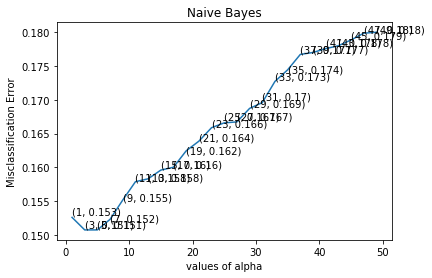

the misclassification error for each <alpha> value is :[ 0.153  0.151  0.151  0.152  0.155  0.158  0.158  0.16   0.16   0.162
  0.164  0.166  0.167  0.167  0.169  0.17   0.173  0.174  0.177  0.177
  0.178  0.178  0.179  0.18   0.18 ] 



Fitting the model with <alpha> value 3

The accuracy of the naive bayes classifier for the <alpha> value = 3 is 86.200000%
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.88      0.87      0.87      1621
          1       0.85      0.85      0.85      1379

avg / total       0.86      0.86      0.86      3000

The classification report is None


In [30]:
## Fitting the mode with cross - validation
model_nb(train_x, train_y, test_x, test_y, sim_cv=True)

**Support Vector Machines**


The optimal C is 0.


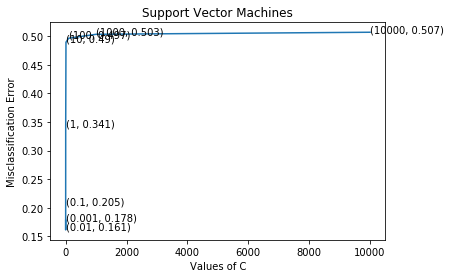

the misclassification error for each C value is :[ 0.178  0.161  0.205  0.341  0.49   0.497  0.503  0.507] 



Fitting the model with C value 0.01

The accuracy of the Support Vector Machine classifier for C = 0 is 83.066667%


In [10]:
model_svm(train_x=train_x,train_y=train_y, test_x=test_x, test_y=test_y)

**Decision - Tree**

**Sampling the data to 70 percent of 10000 observations due to computational constraints.**

In [9]:
fil_df, fil_vec = sample_data(bow, final_df, 70)

total = fil_df.shape[0]
   
## Index at which the data is to be sliced, Here the 70% is train and the rest is test 30%.
index = round((total/ 100) * 70)
print("The index at which the data is sliced {0}".format(index))
train_y = fil_df['score_labels'].values[:index]
test_y = fil_df['score_labels'].values[index:]    
train_x = fil_vec[:index]
test_x = fil_vec[index:]

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


The index at which the data is sliced 4900


In [10]:
print(' The shape of training data train_X: {0} train_Y: {1} \n The shape of the test data test_X:{2} test_Y{3}'.format(train_x.shape, train_y.shape, test_x.shape, test_y.shape))

 The shape of training data train_X: (4900, 21326) train_Y: (4900,) 
 The shape of the test data test_X:(2100, 21326) test_Y(2100,)


In [13]:
# Model with default depth value
model_dt(train_x, train_y, test_x, test_y)

Decision tree with default depth
----------------------------------------------------------------------------------------------------
The confusion matrix is: [[779 340]
 [283 698]]
----------------------------------------------------------------------------------------------------
The accuracy of the model is: 70.3333333333
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.73      0.70      0.71      1119
          1       0.67      0.71      0.69       981

avg / total       0.70      0.70      0.70      2100

The classification report is None


Decision tree with 10 fold cross - validation(with choice of <depth> value)

The optimal valus of <depth> is 21.


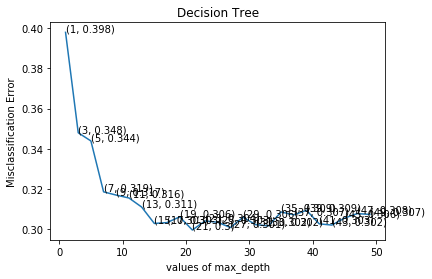

the misclassification error for each <depth> value is :[ 0.398  0.348  0.344  0.319  0.317  0.316  0.311  0.303  0.303  0.306  0.3
  0.304  0.303  0.301  0.306  0.302  0.302  0.309  0.307  0.309  0.303
  0.302  0.306  0.308  0.307] 



Fitting the model with <depth> value 21

The accuracy of the Decision Tree classifier for the <depth> value = 21 is 72.619048%


In [11]:
model_dt(train_x, train_y, test_x, test_y, sim_cv = True)

**Random Forest**

In [7]:
bow = np.load('final_bow.npy', mmap_mode='r+')

In [10]:
fil_df, fil_vec = sample_data(bow, df, 100)

total = fil_df.shape[0]
    
## Index at which the data is to be sliced.
index_bow = round((total/ 100) * 70)

train_y = fil_df['score_labels'].values[:index_bow]
test_y = fil_df['score_labels'].values[index_bow:]  


## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index_bow)
train_x = fil_vec[:index_bow]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = fil_vec[index_bow:]
# print(test_x.shape)
print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


The index at which the data to be splitted: 7000
The train_x shape is: (7000, 21326) train_y shape is (7000,)
The test_x shape is: (3000, 21326) test_y shape is (3000,)



The optimal number of estimators are 400.


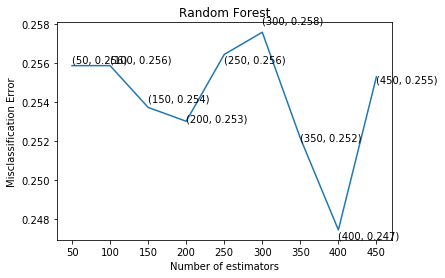


The accuracy of the RandomForest classifier for n_estimators = 400 is 84.866667%


In [11]:
random_forest(train_x, train_y, test_x, test_y)

## TF - IDF(Unigram)

In [4]:

tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final_df['Text'].values)
final_tf_idf = final_tf_idf.toarray()

In [5]:
np.save('final-unigram-tfidf.npy', final_tf_idf)

**KNN** (As KNN is distance based model. In case of high dimensional data it fails)

In [7]:
tfidf = np.load('final-unigram-tfidf.npy', mmap_mode='r+')

In [8]:
## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index)
train_x = tfidf[:index]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = tfidf[index:]

print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

The index at which the data to be splitted: 7000
The train_x shape is: (7000, 21326) train_y shape is (7000,)
The test_x shape is: (3000, 21326) test_y shape is (3000,)



The optimal number of neighbors is 49.


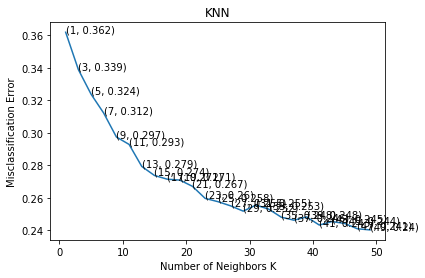

the misclassification error for each k value is :[ 0.362  0.339  0.324  0.312  0.297  0.293  0.279  0.274  0.271  0.271
  0.267  0.26   0.258  0.255  0.252  0.255  0.253  0.248  0.246  0.248
  0.243  0.245  0.244  0.241  0.24 ] 



Fitting the model with K value 49

The accuracy of the knn classifier for k = 49 is 76.366667%


In [9]:
model_knn(train_x, train_y, test_x, test_y)

**Naive Bayes**

In [ ]:
tfidf = np.load('final-unigram-tfidf.npy', mmap_mode='r+')

In [ ]:
## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index)
train_x = tfidf[:index]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = tfidf[index:]

print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

In [11]:
## Fitting the model with out cross - validataion
model_nb(train_x, train_y, test_x, test_y, sim_cv=False)

Naive bayes with out cross - validation(with default <alpha> value)
----------------------------------------------------------------------------------------------------
The confusion matrix is: [[1313  308]
 [ 140 1239]]
----------------------------------------------------------------------------------------------------
The accuracy of the model is: 85.0666666667
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.81      0.85      1621
          1       0.80      0.90      0.85      1379

avg / total       0.86      0.85      0.85      3000

The classification report is None


Naive bayes with cross - validation(with choice of <alpha> value)

The optimal valus of <alpha> is 1.


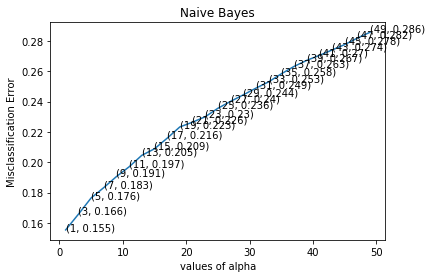

the misclassification error for each <alpha> value is :[ 0.155  0.166  0.176  0.183  0.191  0.197  0.205  0.209  0.216  0.223
  0.226  0.23   0.236  0.24   0.244  0.249  0.253  0.258  0.263  0.267
  0.27   0.274  0.278  0.282  0.286] 



Fitting the model with <alpha> value 1

The accuracy of the naive bayes classifier for the <alpha> value = 1 is 85.066667%
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.81      0.85      1621
          1       0.80      0.90      0.85      1379

avg / total       0.86      0.85      0.85      3000

The classification report is None


In [12]:
## Fitting the mode with cross - validation
model_nb(train_x, train_y, test_x, test_y, sim_cv=True)

**Naive bayes is a COUNT based Mchine Learning algorithm, As counts cannot be negative. So, we cannot apply on AVG - W2V, Tfidf weighted W2V, Google W2v and tfidf weighted Google w2v.(it contains the -ve values).**

**Decision - Tree**

In [ ]:
tfidf = np.load('final-unigram-tfidf.npy', mmap_mode='r+')


**Sampling the data to 70 percent of 10000 observations due to computational constraints.**

In [21]:
fil_df, fil_vec = sample_data(tfidf, final_df, 70)

total = fil_df.shape[0]
   
## Index at which the data is to be sliced, Here the 70% is train and the rest is test 30%.
index = round((total/ 100) * 70)
print("The index at which the data is sliced {0}".format(index))
train_y = fil_df['score_labels'].values[:index]
test_y = fil_df['score_labels'].values[index:]    
train_x = fil_vec[:index]
test_x = fil_vec[index:]

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


The index at which the data is sliced 4900


In [22]:
# Model with default depth value
model_dt(train_x, train_y, test_x, test_y)

Decision tree with default depth
----------------------------------------------------------------------------------------------------
The confusion matrix is: [[758 361]
 [292 689]]
----------------------------------------------------------------------------------------------------
The accuracy of the model is: 68.9047619048
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.68      0.70      1119
          1       0.66      0.70      0.68       981

avg / total       0.69      0.69      0.69      2100

The classification report is None


Decision tree with 10 fold cross - validation(with choice of <depth> value)

The optimal valus of <depth> is 13.


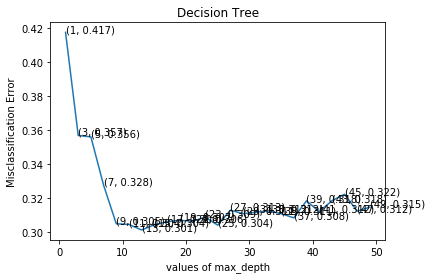

the misclassification error for each <depth> value is :[ 0.417  0.357  0.356  0.328  0.305  0.304  0.301  0.304  0.306  0.307
  0.306  0.309  0.304  0.313  0.311  0.312  0.312  0.311  0.308  0.318
  0.312  0.318  0.322  0.312  0.315] 



Fitting the model with <depth> value 13

The accuracy of the Decision Tree classifier for the <depth> value = 13 is 70.904762%


In [23]:
# Model with choice of depth
model_dt(train_x, train_y, test_x, test_y, sim_cv = True)

**Random Forest**

In [19]:
tfidf = np.load('final-unigram-tfidf.npy', mmap_mode='r+')

In [20]:
fil_df, fil_vec = sample_data(tfidf, df, 100)

total = fil_df.shape[0]
 
## Index at which the data is to be sliced.
index_tfidf = round((total/ 100) * 70)

train_y = fil_df['score_labels'].values[:index_tfidf]
test_y = fil_df['score_labels'].values[index_tfidf:]  


## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index_tfidf)
train_x = fil_vec[:index_tfidf]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = fil_vec[index_tfidf:]
# print(test_x.shape)
print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


The index at which the data to be splitted: 7000
The train_x shape is: (7000, 21326) train_y shape is (7000,)
The test_x shape is: (3000, 21326) test_y shape is (3000,)



The optimal number of estimators are 300.


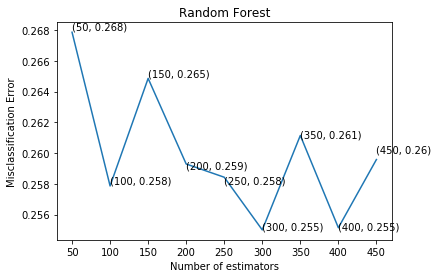


The accuracy of the RandomForest classifier for n_estimators = 300 is 84.366667%


In [21]:
random_forest(train_x, train_y, test_x, test_y)

## TF-IDF(Unigram + Bigram)

In [ ]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_df['Text'].values)
final_tf_idf = final_tf_idf.toarray()

In [ ]:
np.save('final-tfidf.npy', final_tf_idf)

**Logistic regression**

In [8]:
tfidf = np.load('final-tfidf.npy')

In [9]:
sam_df, sam_vec = sample_data(tfidf, df, 5000)

In [10]:
sam_df.shape

(5000, 13)

In [11]:
sam_vec.shape

(5000, 277932)

In [12]:
## Train - test split (Time - bases slicing)
tf_index = round((5000/100) * 70)
tf_train_y = sam_df['score_labels'].values[:tf_index]
tf_test_y = sam_df['score_labels'].values[tf_index:]
print("The index at which the data to be splitted:", tf_index)
tf_train_x = sam_vec[:tf_index]

print("The train_x shape is: {0} train_y shape is {1}".format(tf_train_x.shape, tf_train_y.shape))
tf_test_x = sam_vec[tf_index:]

print("The test_x shape is: {0} test_y shape is {1}".format(tf_test_x.shape, tf_test_y.shape))

The index at which the data to be splitted: 3500
The train_x shape is: (3500, 277932) train_y shape is (3500,)
The test_x shape is: (1500, 277932) test_y shape is (1500,)


In [21]:
# Model with "grid search" and L2 regularization
model_log(tf_train_x, tf_train_y, tf_test_x, tf_test_y, sim_cv=True, grid=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L2 regulrization - Grid Search
The best parameters are:
{'C': 100}
The accuracy of the model is 0.878


In [13]:
# Model with "random search" and L2 regularization
model_log(tf_train_x, tf_train_y, tf_test_x, tf_test_y, sim_cv=True, random=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L2 regularization - Random Search
The best parameters are:
{'C': 1.3848515609998522}
The accuracy of the model is 0.857333333333


In [23]:
# Model with "grid search" and L1 regularization
model_log(tf_train_x, tf_train_y, tf_test_x, tf_test_y, sim_cv=True,grid=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L1 regulrization - Grid Search
The best parameters are:
{'C': 10000}
The accuracy of the model is 0.857333333333


In [20]:
# Model with "random search" and L1 regularization
model_log(tf_train_x, tf_train_y, tf_test_x, tf_test_y, sim_cv=True,random=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L1 regularization - Random Search
The best parameters are:
{'C': 1.9664101902688058}
The accuracy of the model is 0.838


In [25]:
# Sparsity calculation with increase in the value of lambda.
model_log(tf_train_x, tf_train_y, tf_test_x, tf_test_y, sparse=True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
3. Sparsity with increase in <lambda>(i.e, decrease in C)
The model accuracy is: 80.0666666667
The model accuracy is: 46.3333333333
The model accuracy is: 53.6666666667
The model accuracy is: 53.6666666667
The model accuracy is: 53.6666666667
The model accuracy is: 53.6666666667
The model accuracy is: 53.6666666667
The model accuracy is: 53.6666666667
The model accuracy is: 53.6666666667
The model accuracy is: 53.6666666667
The sparsity with L1 regularization is [array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]),

**Support Vector Machines**

In [ ]:
## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index)
train_x = tfidf[:index]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = tfidf[index:]

print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))


The optimal C is 0.


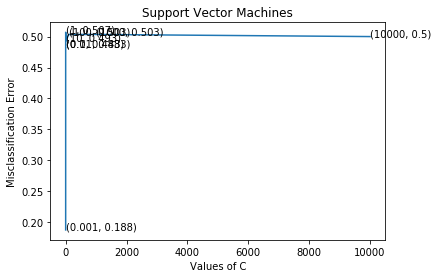

the misclassification error for each C value is :[ 0.188  0.483  0.483  0.507  0.493  0.503  0.503  0.5  ] 



Fitting the model with C value 0.001

The accuracy of the Support Vector Machine classifier for C = 0 is 80.266667%


In [27]:
model_svm(train_x=train_x,train_y=train_y, test_x=test_x, test_y=test_y)

## word2vec

In [6]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [7]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final_df['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [23]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


In [24]:
words = list(w2v_model.wv.vocab)
print(len(words))

6472


In [9]:
np.save('list_of_sent.npy', list_of_sent)

## Avg W2V

In [25]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

10000
50


In [26]:
np.save('avg-W2V.npy', sent_vectors)

In [14]:
avwv = np.load('avg-W2V.npy')

In [15]:
## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index)
train_x = avwv[:index]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = avwv[index:]

print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

The index at which the data to be splitted: 7000
The train_x shape is: (7000, 50) train_y shape is (7000,)
The test_x shape is: (3000, 50) test_y shape is (3000,)


**Logistic regression**

In [36]:
# Model with "grid search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, grid=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L2 regulrization - Grid Search
The best parameters are:
{'C': 10}
The accuracy of the model is 0.779666666667


In [16]:
# Model with "random search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, random=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L2 regularization - Random Search
The best parameters are:
{'C': 1.1985550910731617}
The accuracy of the model is 0.773666666667


In [22]:
# Model with "grid search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,grid=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L1 regulrization - Grid Search
The best parameters are:
{'C': 10}
The accuracy of the model is 0.779


In [34]:
# Model with "random search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,random=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L1 regularization - Random Search
The best parameters are:
{'C': 2.2440010877611223}
The accuracy of the model is 0.777666666667


In [29]:
# Sparsity calculation with increase in the value of lambda.
model_log(train_x, train_y, test_x, test_y, sparse=True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
3. Sparsity with increase in <lambda>(i.e, decrease in C)
The model accuracy is: 77.2666666667
The model accuracy is: 76.5666666667
The model accuracy is: 70.8333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The sparsity with L1 regularization is [array([[ 1.64030882,  0.32708244,  0.        ,  0.94798895, -2.64392485,
         2.59808411, -0.65923602,  1.8500616 , -0.53658822, -1.41343829,
        -0.94983702, -2.73269702, -2.36279373,  0.        ,  1.69036442,
         1.72175424, -1.9280095 , -1.73919478,  0.72416222, -2.86427869,
        -0.84937844, -3.07824964,  1.61666569, -1.29676728,  2.4589906 ,
         0.51207677,  4.02430021, -2.01047594, -

**KNN**


The optimal number of neighbors is 45.


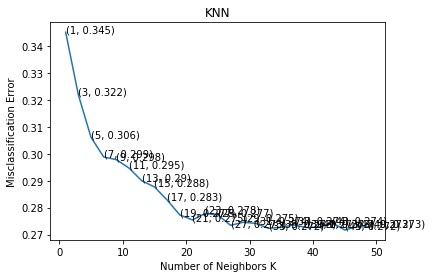

the misclassification error for each k value is :[ 0.345  0.322  0.306  0.299  0.298  0.295  0.29   0.288  0.283  0.277
  0.275  0.278  0.277  0.273  0.275  0.274  0.272  0.273  0.274  0.273
  0.273  0.274  0.272  0.273  0.273] 



Fitting the model with K value 45

The accuracy of the knn classifier for k = 45 is 73.633333%


In [10]:
model_knn(train_x, train_y, test_x, test_y)

**Support vector machines**


The optimal C is 0.


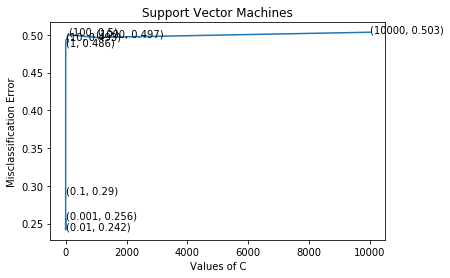

the misclassification error for each C value is :[ 0.256  0.242  0.29   0.486  0.493  0.5    0.497  0.503] 



Fitting the model with C value 0.01

The accuracy of the Support Vector Machine classifier for C = 0 is 76.266667%


In [16]:
model_svm(train_x=train_x,train_y=train_y, test_x=test_x, test_y=test_y)

**Decision - Tree**

In [12]:
avwv = np.load('avg-W2V.npy', mmap_mode='r+')

In [19]:
# Here we take the complete data.
fil_df, fil_vec = sample_data(avwv, df, 100)

total = fil_df.shape[0]
   
## Index at which the data is to be sliced, Here the 70% is train and the rest is test 30%.
index = round((total/ 100) * 70)
print("The index at which the data is sliced {0}".format(index))
train_y = fil_df['score_labels'].values[:index]
test_y = fil_df['score_labels'].values[index:]    
train_x = fil_vec[:index]
test_x = fil_vec[index:]

The index at which the data is sliced 7000


C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [20]:
# Model with no choice of max_depth(default depth)
model_dt(train_x, train_y, test_x, test_y, sim_cv=False)

Decision tree with default depth
----------------------------------------------------------------------------------------------------
The confusion matrix is: [[1030  591]
 [ 491  888]]
----------------------------------------------------------------------------------------------------
The accuracy of the model is: 63.9333333333
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.68      0.64      0.66      1621
          1       0.60      0.64      0.62      1379

avg / total       0.64      0.64      0.64      3000

The classification report is None


Decision tree with 10 fold cross - validation(with choice of <depth> value)

The optimal valus of <depth> is 5.


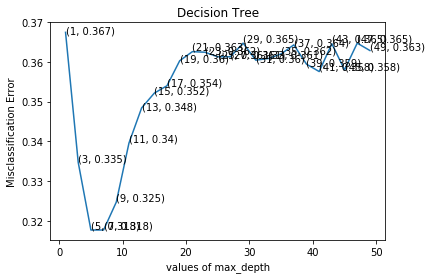

the misclassification error for each <depth> value is :[ 0.367  0.335  0.318  0.318  0.325  0.34   0.348  0.352  0.354  0.36
  0.363  0.362  0.361  0.361  0.365  0.36   0.361  0.362  0.364  0.359
  0.358  0.365  0.358  0.365  0.363] 



Fitting the model with <depth> value 5

The accuracy of the Decision Tree classifier for the <depth> value = 5 is 69.266667%


In [21]:
# Model with choice of max_depth( using cross - validation)
model_dt(train_x, train_y, test_x, test_y, sim_cv=True)

**Random Forest**

In [7]:
avwv = np.load('avg-W2V.npy', mmap_mode='r+')

In [8]:
fil_df, fil_vec = sample_data(avwv, df, 100)

total = fil_df.shape[0]
 
## Index at which the data is to be sliced.
index_avwv = round((total/ 100) * 70)

train_y = fil_df['score_labels'].values[:index_tfidf]
test_y = fil_df['score_labels'].values[index_tfidf:]  


## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index_tfidf)
train_x = fil_vec[:index_avwv]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = fil_vec[index_avwv:]
# print(test_x.shape)
print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


The index at which the data to be splitted: 7000
The train_x shape is: (7000, 50) train_y shape is (7000,)
The test_x shape is: (3000, 50) test_y shape is (3000,)



The optimal number of estimators are 250.


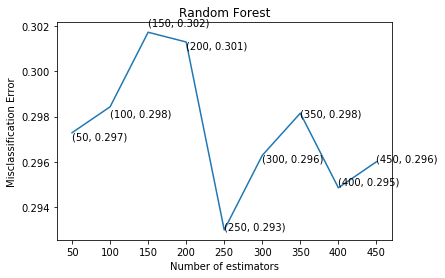


The accuracy of the RandomForest classifier for n_estimators = 250 is 75.866667%


In [9]:
random_forest(train_x, train_y, test_x, test_y)

## TFIDF - W2V

In [27]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [28]:
np.save('tf-idf-w2v.npy', tfidf_sent_vectors)

In [29]:
tf_idf_w2v = np.load('tf-idf-w2v.npy')

In [17]:
tfw2v = np.load('tf-idf-w2v.npy')

**Logistic regression**

In [18]:
## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index)
train_x = tfw2v[:index]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = tfw2v[index:]

print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

The index at which the data to be splitted: 7000
The train_x shape is: (7000, 50) train_y shape is (7000,)
The test_x shape is: (3000, 50) test_y shape is (3000,)


In [63]:
# Model with "grid search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, grid=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L2 regulrization - Grid Search
The best parameters are:
{'C': 1000}
The accuracy of the model is 0.756333333333


In [19]:
# Model with "random search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, random=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L2 regularization - Random Search
The best parameters are:
{'C': 1.7758698850844856}
The accuracy of the model is 0.754


In [65]:
# Model with "grid search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,grid=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L1 regulrization - Grid Search
The best parameters are:
{'C': 10000}
The accuracy of the model is 0.756333333333


In [66]:
# Model with "random search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,random=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L1 regularization - Random Search
The best parameters are:
{'C': 1.5235559900932036}
The accuracy of the model is 0.755333333333


In [67]:
# Sparsity calculation with increase in the value of lambda.
model_log(train_x, train_y, test_x, test_y, sparse=True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
3. Sparsity with increase in <lambda>(i.e, decrease in C)
The model accuracy is: 75.3
The model accuracy is: 73.8666666667
The model accuracy is: 68.5333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The sparsity with L1 regularization is [array([[ 1.0565042 , -0.15196487,  0.03330533,  0.91411329, -2.56034335,
         2.38888328, -1.50396229,  1.35196309, -2.12523184, -0.99315616,
        -0.86923909, -1.92206105, -1.89282403,  0.40710953,  2.21884208,
         0.93434168, -1.50635902, -0.97424851,  0.66338823, -1.87539085,
        -0.9773808 , -2.30689318,  2.18410367, -1.02780722,  0.81818166,
         0.64028841,  3.72516069, -3.03277224, -1.3885375

**KNN**


The optimal number of neighbors is 33.


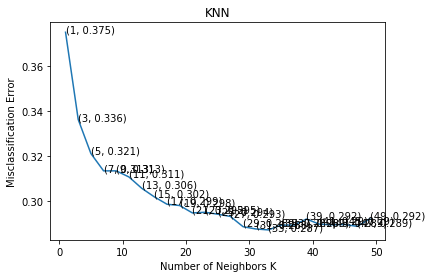

the misclassification error for each k value is :[ 0.375  0.336  0.321  0.313  0.313  0.311  0.306  0.302  0.299  0.298
  0.295  0.295  0.294  0.293  0.289  0.288  0.287  0.289  0.289  0.292
  0.29   0.289  0.29   0.289  0.292] 



Fitting the model with K value 33

The accuracy of the knn classifier for k = 33 is 71.000000%


In [13]:
model_knn(train_x, train_y, test_x, test_y)

**Support vector machines**


The optimal C is 0.


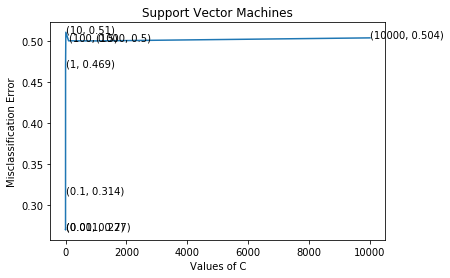

the misclassification error for each C value is :[ 0.27   0.27   0.314  0.469  0.51   0.5    0.5    0.504] 



Fitting the model with C value 0.01

The accuracy of the Support Vector Machine classifier for C = 0 is 72.066667%


In [19]:
model_svm(train_x=train_x,train_y=train_y, test_x=test_x, test_y=test_y)

**Decision - Tree**

In [22]:
tfw2v = np.load('tf-idf-w2v.npy', mmap_mode='r+')

In [23]:
# Here we take the complete data.
fil_df, fil_vec = sample_data(tfw2v, df, 100)

total = fil_df.shape[0]
   
## Index at which the data is to be sliced, Here the 70% is train and the rest is test 30%.
index = round((total/ 100) * 70)
print("The index at which the data is sliced {0}".format(index))
train_y = fil_df['score_labels'].values[:index]
test_y = fil_df['score_labels'].values[index:]    
train_x = fil_vec[:index]
test_x = fil_vec[index:]

The index at which the data is sliced 7000


C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [24]:
# Model with no choice of max_depth(default depth)
model_dt(train_x, train_y, test_x, test_y, sim_cv=False)

Decision tree with default depth
----------------------------------------------------------------------------------------------------
The confusion matrix is: [[991 630]
 [499 880]]
----------------------------------------------------------------------------------------------------
The accuracy of the model is: 62.3666666667
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.67      0.61      0.64      1621
          1       0.58      0.64      0.61      1379

avg / total       0.63      0.62      0.62      3000

The classification report is None


Decision tree with 10 fold cross - validation(with choice of <depth> value)

The optimal valus of <depth> is 5.


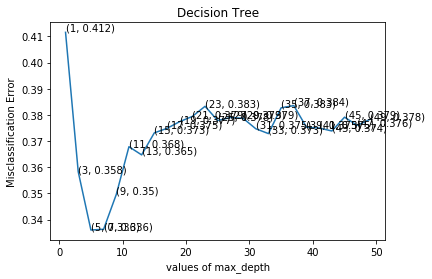

the misclassification error for each <depth> value is :[ 0.412  0.358  0.336  0.336  0.35   0.368  0.365  0.373  0.375  0.377
  0.379  0.383  0.378  0.379  0.379  0.375  0.373  0.383  0.384  0.375
  0.375  0.374  0.379  0.376  0.378] 



Fitting the model with <depth> value 5

The accuracy of the Decision Tree classifier for the <depth> value = 5 is 63.600000%


In [25]:
# Model with choice of max_depth( using cross - validation)
model_dt(train_x, train_y, test_x, test_y, sim_cv=True)

**Random Forest**

In [10]:
tfw2v = np.load('tf-idf-w2v.npy', mmap_mode='r+')

In [11]:
fil_df, fil_vec = sample_data(tfw2v, df, 100)

total = fil_df.shape[0]
 
## Index at which the data is to be sliced.
index_tfw2v = round((total/ 100) * 70)

train_y = fil_df['score_labels'].values[:index_tfw2v]
test_y = fil_df['score_labels'].values[index_tfw2v:]  


## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index_tfw2v)
train_x = fil_vec[:index_tfw2v]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = fil_vec[index_tfw2v:]
# print(test_x.shape)
print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


The index at which the data to be splitted: 7000
The train_x shape is: (7000, 50) train_y shape is (7000,)
The test_x shape is: (3000, 50) test_y shape is (3000,)



The optimal number of estimators are 150.


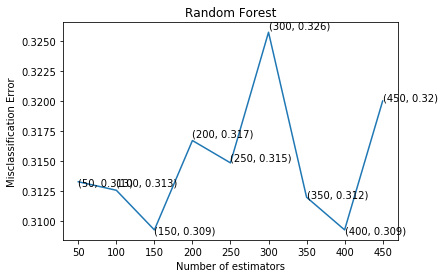


The accuracy of the RandomForest classifier for n_estimators = 150 is 72.666667%


In [12]:
random_forest(train_x, train_y, test_x, test_y)

In [10]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)



In [15]:
len(model.wv['computer'])

300

## Google AVG - W2V.

In [16]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

10000
300


In [17]:
np.save('final-google-avg-w2v.npy',sent_vectors)

In [9]:
goo_avg_w2v = np.load('final-google-avg-w2v.npy', mmap_mode='r+')

In [10]:
## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index)
train_x = goo_avg_w2v[:index]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = goo_avg_w2v[index:]

print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

The index at which the data to be splitted: 7000
The train_x shape is: (7000, 300) train_y shape is (7000,)
The test_x shape is: (3000, 300) test_y shape is (3000,)


**Logistic regression**

In [11]:
# Model with "grid search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, grid=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L2 regulrization - Grid Search
The best parameters are:
{'C': 10}
The accuracy of the model is 0.842666666667


In [12]:
# Model with "random search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, random=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L2 regularization - Random Search
The best parameters are:
{'C': 2.7120459138304915}
The accuracy of the model is 0.837


In [13]:
# Model with "grid search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,grid=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L1 regulrization - Grid Search
The best parameters are:
{'C': 100}
The accuracy of the model is 0.838


In [14]:
# Model with "random search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,random=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L1 regularization - Random Search
The best parameters are:
{'C': 2.3262187959317475}
The accuracy of the model is 0.839333333333


In [15]:
# Sparsity calculation with increase in the value of lambda.
model_log(train_x, train_y, test_x, test_y, sparse=True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
3. Sparsity with increase in <lambda>(i.e, decrease in C)
The model accuracy is: 82.9333333333
The model accuracy is: 77.3
The model accuracy is: 45.9666666667
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The sparsity with L1 regularization is [array([[ -3.51863487,   0.        ,  -6.60972546,   0.        ,
          3.063442  ,  -3.91302899,  -0.58600426,   0.        ,
         -2.88654342,   0.        ,   0.        ,   0.        ,
          0.44308179,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   3.27612637,
          0.        ,   0.        ,   0.        ,   2.58834588,
         -1.20639838,  -1.14180344,  -

**KNN**


The optimal number of neighbors is 45.


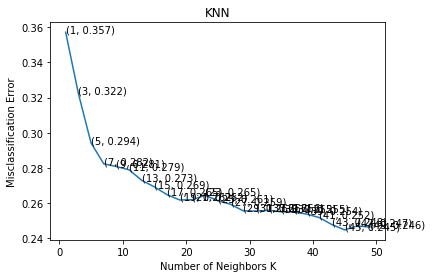

the misclassification error for each k value is :[ 0.357  0.322  0.294  0.282  0.281  0.279  0.273  0.269  0.265  0.262
  0.262  0.265  0.261  0.259  0.256  0.256  0.256  0.255  0.255  0.254
  0.252  0.248  0.245  0.247  0.246] 



Fitting the model with K value 45

The accuracy of the knn classifier for k = 45 is 75.933333%


In [9]:
model_knn(train_x, train_y, test_x, test_y)

**Support Vector Machines**


The optimal C is 0.


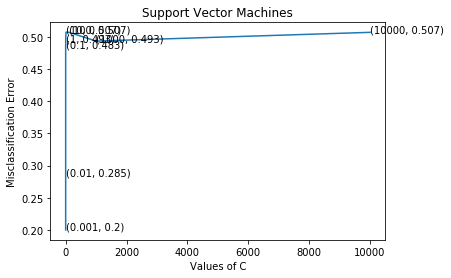

the misclassification error for each C value is :[ 0.2    0.285  0.483  0.493  0.507  0.507  0.493  0.507] 



Fitting the model with C value 0.001

The accuracy of the Support Vector Machine classifier for C = 0 is 80.600000%


In [32]:
model_svm(train_x=train_x,train_y=train_y, test_x=test_x, test_y=test_y)

**Decision - Tree**

In [11]:
goo_avg_w2v = np.load('final-google-avg-w2v.npy', mmap_mode='r+')

In [13]:
# Here we take the complete data.
fil_df, fil_vec = sample_data(goo_avg_w2v, df, 100)

total = fil_df.shape[0]
   
## Index at which the data is to be sliced, Here the 70% is train and the rest is test 30%.
index = round((total/ 100) * 70)
print("The index at which the data is sliced {0}".format(index))
train_y = fil_df['score_labels'].values[:index]
test_y = fil_df['score_labels'].values[index:]    
train_x = fil_vec[:index]
test_x = fil_vec[index:]

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


The index at which the data is sliced 7000


In [14]:
# Model with no choice of max_depth(default depth)
model_dt(train_x, train_y, test_x, test_y, sim_cv=False)

Decision tree with default depth
----------------------------------------------------------------------------------------------------
The confusion matrix is: [[1005  616]
 [ 460  919]]
----------------------------------------------------------------------------------------------------
The accuracy of the model is: 64.1333333333
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.69      0.62      0.65      1621
          1       0.60      0.67      0.63      1379

avg / total       0.65      0.64      0.64      3000

The classification report is None


Decision tree with 10 fold cross - validation(with choice of <depth> value)

The optimal valus of <depth> is 5.


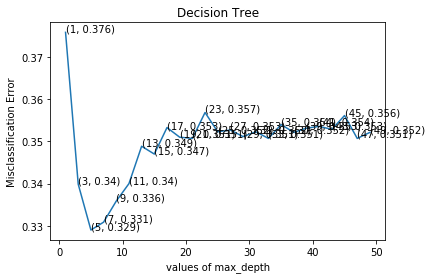

the misclassification error for each <depth> value is :[ 0.376  0.34   0.329  0.331  0.336  0.34   0.349  0.347  0.353  0.351
  0.351  0.357  0.352  0.353  0.351  0.352  0.351  0.354  0.352  0.353
  0.354  0.353  0.356  0.351  0.352] 



Fitting the model with <depth> value 5

The accuracy of the Decision Tree classifier for the <depth> value = 5 is 67.066667%


In [15]:
# Model with choice of max_depth(using cross - validation)
model_dt(train_x, train_y, test_x, test_y, sim_cv=True)

**Random Forest**

In [13]:
goo_avg_w2v = np.load('final-google-avg-w2v.npy', mmap_mode='r+')

In [14]:
fil_df, fil_vec = sample_data(goo_avg_w2v, df, 100)

total = fil_df.shape[0]
 
## Index at which the data is to be sliced.
index_goo_avg_w2v = round((total/ 100) * 70)

train_y = fil_df['score_labels'].values[:index_goo_avg_w2v]
test_y = fil_df['score_labels'].values[index_goo_avg_w2v:]  


## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index_goo_avg_w2v)
train_x = fil_vec[:index_goo_avg_w2v]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = fil_vec[index_goo_avg_w2v:]
# print(test_x.shape)
print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


The index at which the data to be splitted: 7000
The train_x shape is: (7000, 300) train_y shape is (7000,)
The test_x shape is: (3000, 300) test_y shape is (3000,)



The optimal number of estimators are 50.


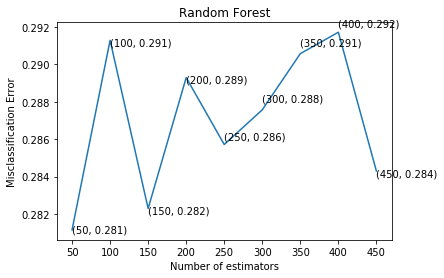


The accuracy of the RandomForest classifier for n_estimators = 50 is 76.400000%


In [15]:
random_forest(train_x, train_y, test_x, test_y)

## Google TFIDF weighted AVG - W2V.

In [28]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [29]:
np.save('final-google-tfidf-avg-w2v.npy', tfidf_sent_vectors)

In [16]:
goo_tfidf_avg_w2v = np.load('final-google-tfidf-avg-w2v.npy', mmap_mode='r+')

In [17]:
## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index)
train_x = goo_tfidf_avg_w2v[:index]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = goo_tfidf_avg_w2v[index:]

print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

The index at which the data to be splitted: 7000
The train_x shape is: (7000, 300) train_y shape is (7000,)
The test_x shape is: (3000, 300) test_y shape is (3000,)


**Logistic regression**

In [18]:
# Model with "grid search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, grid=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L2 regulrization - Grid Search
The best parameters are:
{'C': 100}
The accuracy of the model is 0.792666666667


In [19]:
# Model with "random search" and L2 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True, random=1)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L2 regularization - Random Search
The best parameters are:
{'C': 1.88169269625812}
The accuracy of the model is 0.799333333333


In [20]:
# Model with "grid search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,grid=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
1. Logistic regression with L1 regulrization - Grid Search
The best parameters are:
{'C': 10}
The accuracy of the model is 0.793


In [21]:
# Model with "random search" and L1 regularization
model_log(train_x, train_y, test_x, test_y, sim_cv=True,random=1, l1 = True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
2. Logistic regression with L1 regularization - Random Search
The best parameters are:
{'C': 2.7142779474953982}
The accuracy of the model is 0.795333333333


In [22]:
# Sparsity calculation with increase in the value of lambda.
model_log(train_x, train_y, test_x, test_y, sparse=True)

Logistic regression with cross - validation choice of regularization(L1, L2) with best possible values of <Lambda / C>
3. Sparsity with increase in <lambda>(i.e, decrease in C)
The model accuracy is: 79.6666666667
The model accuracy is: 74.5
The model accuracy is: 45.9666666667
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The model accuracy is: 54.0333333333
The sparsity with L1 regularization is [array([[ -2.79339537e+00,   0.00000000e+00,  -4.55560007e+00,
          0.00000000e+00,   1.60067540e+00,  -8.82966009e-01,
         -1.56312237e+00,  -3.80384573e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.71633940e-01,
          2.35316230e+00,  -9.08250493e-01,   7.75479493e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.81210204e-01,   2.15741197e+00,   0.00

**KNN**


The optimal number of neighbors is 49.


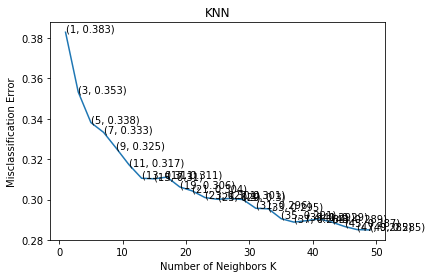

the misclassification error for each k value is :[ 0.383  0.353  0.338  0.333  0.325  0.317  0.311  0.31   0.311  0.306
  0.304  0.301  0.3    0.301  0.3    0.296  0.295  0.291  0.289  0.29   0.29
  0.289  0.287  0.285  0.285] 



Fitting the model with K value 49

The accuracy of the knn classifier for k = 49 is 70.566667%


In [13]:
model_knn(train_x, train_y, test_x, test_y)

**Support Vector Machines**


The optimal C is 0.


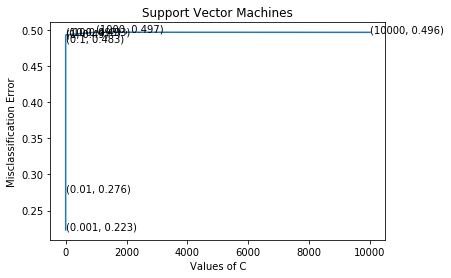

the misclassification error for each C value is :[ 0.223  0.276  0.483  0.49   0.493  0.493  0.497  0.496] 



Fitting the model with C value 0.001

The accuracy of the Support Vector Machine classifier for C = 0 is 77.833333%


In [35]:
model_svm(train_x=train_x,train_y=train_y, test_x=test_x, test_y=test_y)

**Decision - Tree**

In [16]:
goo_tfidf_w2v = np.load("final-google-tfidf-avg-w2v.npy", mmap_mode='r+')

In [17]:
# Here we take the complete data.
fil_df, fil_vec = sample_data(goo_tfidf_w2v, df, 100)

total = fil_df.shape[0]
   
## Index at which the data is to be sliced, Here the 70% is train and the rest is test 30%.
index = round((total/ 100) * 70)
print("The index at which the data is sliced {0}".format(index))
train_y = fil_df['score_labels'].values[:index]
test_y = fil_df['score_labels'].values[index:]    
train_x = fil_vec[:index]
test_x = fil_vec[index:]

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


The index at which the data is sliced 7000


In [18]:
# Model with no choice of max_depth(default depth)
model_dt(train_x, train_y, test_x, test_y, sim_cv=False)

Decision tree with default depth
----------------------------------------------------------------------------------------------------
The confusion matrix is: [[963 658]
 [521 858]]
----------------------------------------------------------------------------------------------------
The accuracy of the model is: 60.7
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.65      0.59      0.62      1621
          1       0.57      0.62      0.59      1379

avg / total       0.61      0.61      0.61      3000

The classification report is None


Decision tree with 10 fold cross - validation(with choice of <depth> value)

The optimal valus of <depth> is 7.


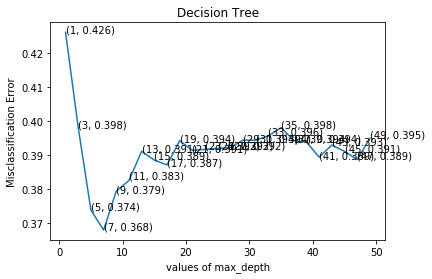

the misclassification error for each <depth> value is :[ 0.426  0.398  0.374  0.368  0.379  0.383  0.391  0.389  0.387  0.394
  0.391  0.392  0.392  0.392  0.394  0.394  0.396  0.398  0.394  0.394
  0.389  0.393  0.391  0.389  0.395] 



Fitting the model with <depth> value 7

The accuracy of the Decision Tree classifier for the <depth> value = 7 is 62.466667%


In [19]:
# Model with choice of max_depth( using cross - validation)
model_dt(train_x, train_y, test_x, test_y, sim_cv=True)

**Random Forest**

In [16]:
goo_tfidf_w2v = np.load("final-google-tfidf-avg-w2v.npy", mmap_mode='r+')

In [17]:
fil_df, fil_vec = sample_data(goo_tfidf_w2v, df, 100)

total = fil_df.shape[0]
 
## Index at which the data is to be sliced.
index_goo_tfidf_w2v = round((total/ 100) * 70)

train_y = fil_df['score_labels'].values[:index_goo_tfidf_w2v]
test_y = fil_df['score_labels'].values[index_goo_tfidf_w2v:]  


## Train - test split (Time - bases slicing)

print("The index at which the data to be splitted:", index_goo_tfidf_w2v)
train_x = fil_vec[:index_goo_tfidf_w2v]

print("The train_x shape is: {0} train_y shape is {1}".format(train_x.shape, train_y.shape))
test_x = fil_vec[index_goo_tfidf_w2v:]
# print(test_x.shape)
print("The test_x shape is: {0} test_y shape is {1}".format(test_x.shape, test_y.shape))

C:\Users\rahul\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


The index at which the data to be splitted: 7000
The train_x shape is: (7000, 300) train_y shape is (7000,)
The test_x shape is: (3000, 300) test_y shape is (3000,)



The optimal number of estimators are 350.


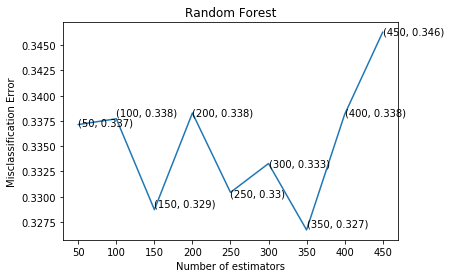


The accuracy of the RandomForest classifier for n_estimators = 350 is 74.433333%


In [18]:
random_forest(train_x, train_y, test_x, test_y)

# Unsupervised learning

## KMeans

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
def text_sim(centers, train, df):
    print("-"*50)
    print("\n 2. Text interpretation of the cluster centers \n")
    print("Using the cosine similarity as the measure between the cluster centers and the Text that corresponds to the cluster center is interpreted \n\n\n\n\n")
    print("-"*50)
    print("The shape of centers is {0} and The shape of vectors is {1}".format(centers.shape, train.shape))
    matrix = cosine_similarity(centers, train)
    
    for i in matrix.tolist():
        print("-"*100)
        print("The index of the review is {}".format(i.index(max(i))))
        print("-"*100)
        print(df['Text'].iloc[i.index(max(i))])
        print("\n\n\n")
    
    return None
    

def kmeans(train):
    clusters = [i for i in range(2, 50, 2)]
    sqloss = []
    final_centers = ""
    for i in clusters:
        kmeans = KMeans(n_clusters=i, n_jobs=-1)
        kmeans.fit(train)
        loss = kmeans.inertia_
        sqloss.append(loss)
    optimal_cluster = clusters[sqloss.index(min(sqloss))]
    
    op_kmeans = KMeans(n_clusters=optimal_cluster)
    op_kmeans.fit(train)
    centers = op_kmeans.cluster_centers_
    final_centers = centers
    print("The squared loss is {}".format(sqloss))
    return final_centers

**This method is for sampling the data.**

In [7]:
def sample_data(vectors, dfra, amount, random = False):
    '''
    Vectors - All the vetors of the words that are converted.
    
    dfra - Data Frame of reviews.
    
    amount - percent amount of data needed.
    
    '''
    # This function is similar to this simple calculation.
    # 75% of 10,000 is ((75/100) * 10000) = 7500
    # Here amount = 75
    points = (amount / 100) * 10000
    
    if(random==False):
        
    
    # The linear saced integers are taken as the data to be divided in accordance with time.
        index = np.linspace(0, 9999, points, dtype=int)
    
        fil_df = dfra.loc[index]
        fil_vec = vectors[index]
        
        return fil_df, fil_vec
    else:
        index = np.random.randint(0, 9999, int(points))
        
        fil_df = dfra.loc[index]
        fil_vec = vectors[index]
        
        return fil_df, fil_vec

**Here, we are using cosine similarities as the measure for determining the ccluster centers to the actual review text. There are chances that the similarity values of the centers could be same and this causes dupicate cluster centers.**

**The possible clusters are taken as the multiples of 2 till 50. The loss is printed for the corresponding cluster assumtions. The final cluster is determined with lowest loss value**

**These are some of the cluster center text interpretations: **
   
   * Chocolates

   * Tuna fish

   * Baking flour,cream, carbs

   * Ginger Beer

   * Coffee

   * Hot Chocolate mix

   * Description of the Amzaon shipping 

   * Green Teas and Black Teas.

   * Kelloggs Spooky Tarts

   * Roasted Nuts.

   * Chocolates
   * Almonds
   * cheese

   * Mixs
   
   * Fruit Punch
   
   * Bracolli.
   * and so on..
   


## BOW

In [17]:
bow = np.load('final_bow.npy')

In [18]:
centers = kmeans(bow)

The squared loss is [1285352.8670449429, 1163311.1523726366, 1124201.7066264083, 1099156.3313883711, 1078267.3640934525, 1062604.7848897702, 1047531.0279401606, 1039428.107098268, 1035320.9706185054, 1024362.5569525653, 1021903.5207431855, 1013101.5956989429, 1009605.040389361, 1003470.9365386575, 998409.7255212008, 994272.65608766931, 991321.29759817035, 988106.9596591969, 984915.47652953572, 979613.96376268344, 978564.63460766315, 972591.19206057373, 971486.21356735157, 970698.56921013421]


In [19]:
text_sim(centers, bow, df)

--------------------------------------------------

 2. Text interpretation of the cluster centers 

Using the cosine similarity as the measure between the cluster centers and the Text that corresponds to the cluster center is interpreted 





--------------------------------------------------
The shape of centers is (48, 21326) and The shape of vectors is (10000, 21326)
----------------------------------------------------------------------------------------------------
The index of the review is 4216
----------------------------------------------------------------------------------------------------
These chocolates seemed like a REALLY good deal. I love Lindor, but the store near me was out of the assorted kind. I wanted some for my sister's birthday party. I got on Amazon and found these, cheap price and free shipping! Wow! So I ordered some.<br /><br />First, they came, and I opened one, and immediately got suspicious. They looked melted, and they were soft. I had read some review

I don't want to be over-negative here -- this product will definitely meet the specific needs of some folks such as those who have little time or, college students who live by microwave cooking. But for the average consumer, this product has some clear drawbacks. There are five facets to my evaluation: ease of preparation, flavor, health aspects/portion size, environmental concerns, and storage, (I'm not including price, which people can weigh for themselves) so I'll enumerate my observations here:<br /><br />1. Preparing the dish is a bit of a pain, compared to the Healthy Choice frozen dinners. It's essentially a five-step process, although I did find it necessary to additionally microwave the "finished" dish for an extra 30 seconds. I found it difficult to read the instructions on the side and on the top due to the tiny font size, but young people will probably not experience this problem. Microwaving the sauce can generate a tiny mess because you pull back a corner of the packet to

## TF-IDF(Unigram)

In [8]:
tfidf = np.load('final-unigram-tfidf.npy', mmap_mode='r+')

** As TF-IDF vector is large dimensional, due to computational constraints only 30 percent of the data is sampled. **

In [9]:
fil_df, fil_vec = sample_data(tfidf, df, 30, random=True)

In [10]:
print("The Shape of the DataFrame is {}".format(fil_vec.shape))

The Shape of the DataFrame is (3000, 21326)


** K Means **

In [11]:
centers = kmeans(fil_vec)

The squared loss is [2802.6455129099113, 2774.0296641005202, 2755.307628809353, 2742.8284687800278, 2735.6559898397177, 2727.3661678110138, 2722.7347851422946, 2712.9316549593223, 2709.7119200293878, 2705.7001446917116, 2697.1458038608525, 2692.8342799943071, 2683.1176685440373, 2683.1765000268306, 2680.1105942617655, 2672.9571298379255, 2666.612343722597, 2665.4355982694065, 2658.6752711398271, 2654.0804164266592, 2651.9663321007442, 2649.2286378996591, 2643.3402642873361, 2635.3796258403786]


In [12]:
text_sim(centers, tfidf, df)

--------------------------------------------------

 2. Text interpretation of the cluster centers 

Using the cosine similarity as the measure between the cluster centers and the Text that corresponds to the cluster center is interpreted 





--------------------------------------------------
The shape of centers is (48, 21326) and The shape of vectors is (10000, 21326)
----------------------------------------------------------------------------------------------------
The index of the review is 356
----------------------------------------------------------------------------------------------------
Who would ever think corn flakes need to be gluten free for some people?  Well, being on this special diet has made me aware!  This brand of cornflakes is delicious and I purchase in quantity because I use cornflakes for many things.  Nice to have something safe and delicious to eat at a reasonable cost.  Hope they never change their recipe....can't fix what isn't broken..




------------

## AVG - W2V

In [6]:
avwv = np.load('avg-W2V.npy')

**K Means**

In [8]:
centers = kmeans(avwv)

The squared loss is [16458.178855725313, 14648.317668101685, 13622.335486359676, 12924.275942960312, 12449.653535915624, 12086.945148314104, 11803.428771273982, 11590.093359253247, 11388.320088310678, 11217.886596174934, 11053.013541638607, 10914.460536304876, 10786.307201843145, 10674.502359495824, 10570.966365853144, 10470.532471024662, 10385.117719853044, 10289.424880499424, 10224.735648743654, 10129.027411596177, 10069.042576795931, 10008.643025195359, 9933.8332167703193, 9882.0432698184486]


In [11]:
text_sim(centers, avwv, df)

--------------------------------------------------

 2. Text interpretation of the cluster centers 

Using the cosine similarity as the measure between the cluster centers and the Text that corresponds to the cluster center is interpreted 





--------------------------------------------------
The shape of centers is (48, 50) and The shape of vectors is (10000, 50)
----------------------------------------------------------------------------------------------------
The index of the review is 5253
----------------------------------------------------------------------------------------------------
This looked like a great deal since the price on the smaller sizes went way up, but for some reason this tasted really different than the individual cans. Less flavor, less chunks, pretty soupy and unappetizing to the extent that I requested a refund.




----------------------------------------------------------------------------------------------------
The index of the review is 3042
--------

## TFIDF - W2V

In [12]:
tfw2v = np.load('tf-idf-w2v.npy')

** K Means **

In [13]:
centers = kmeans(tfw2v)

The squared loss is [24436.080324610932, 21118.640965360752, 19045.480556907205, 17864.141649177222, 17130.290044115631, 16520.395348234018, 15968.49794116864, 15564.690146221194, 15214.205247994243, 14904.308985818776, 14639.705755408328, 14425.935250284692, 14214.890374676144, 14047.365378790184, 13877.427023164711, 13710.920642120551, 13569.251449535446, 13448.083740625429, 13317.941629633966, 13185.264361879124, 13097.6383933541, 13001.203709057607, 12902.627459326746, 12800.933935531346]


In [14]:
text_sim(centers, tfw2v, df)

--------------------------------------------------

 2. Text interpretation of the cluster centers 

Using the cosine similarity as the measure between the cluster centers and the Text that corresponds to the cluster center is interpreted 





--------------------------------------------------
The shape of centers is (48, 50) and The shape of vectors is (10000, 50)
----------------------------------------------------------------------------------------------------
The index of the review is 3381
----------------------------------------------------------------------------------------------------
exceptionally delicious, blends excellenct in my blender bottle, the bottle with the little round whisk. taste better than starbucks. i am completely satisfied with this product. i drink it plain or sometimes i add coffee cream or heavy cream, lots of ice- shake and go. i am partial to the vanilla latte, it is very addictive. if you love coffee and want to get more protein give this product a t

## Google AVG W2V

In [6]:
goo_avg_w2v = np.load('final-google-avg-w2v.npy', mmap_mode='r+')

** K Means **

In [7]:
centers = kmeans(goo_avg_w2v)

The squared loss is [1725.0180812897825, 1639.4831574190453, 1590.5635754534574, 1555.8988797191373, 1529.292436394705, 1508.6733604821304, 1492.2974811223298, 1477.752933117798, 1465.0047127615958, 1452.0707005995394, 1441.9661523672912, 1434.008533247453, 1427.7222964405785, 1418.7774057239346, 1412.9715074609858, 1407.2264585562461, 1400.1900398519763, 1395.4377248330904, 1390.8400681669677, 1385.7122822541223, 1381.6570598223241, 1377.1175675057711, 1371.8572169802726, 1368.562411568241]


In [8]:
text_sim(centers, goo_avg_w2v, df)

--------------------------------------------------

 2. Text interpretation of the cluster centers 

Using the cosine similarity as the measure between the cluster centers and the Text that corresponds to the cluster center is interpreted 





--------------------------------------------------
The shape of centers is (48, 300) and The shape of vectors is (10000, 300)
----------------------------------------------------------------------------------------------------
The index of the review is 3143
----------------------------------------------------------------------------------------------------
Amazon offers no bargain.  The french vanilla cafe pack of 6 is offered for $34.95 plus $10.51 shipping and handling.  Total equals $45.46, which is approximately $7.57 per can.  This is exorbitant.  If you can find the product in a store it is usually in the $5.00 to $5.50 range, which in itself is rather high.  Maxwell House has not only changed the formula, they have made the product harde


----------------------------------------------------------------------------------------------------
The index of the review is 5615
----------------------------------------------------------------------------------------------------
My dog is finally on to me. She's long given up PB on her pills, and has learned to spit out her pills that are wrapped in nitrite free deli meat, causing me to waste quite a bit before she gets it down.<br /><br />Looking for a cheaper alternative, these seem great, but the ingredients are not conducive for optimal health, especially a dog in our situation that has cancer.<br /><br />wheat flour, corn syrup, wheat gluten, vegetable oil should not be on the consumption list for a sick dog, let alone one for cancer. Sadly, my search goes on.<br /><br />Chicken, glycerin, wheat flour, natural flavors, dried corn syrup, corn flour, wheat gluten, chicken liver meal, vegetable oil, lecithin, brewer's dried yeast, potassium sorbate (to preserve freshness), meth

## Google TFIDF - AVG W2V

In [9]:
goo_tfidf_w2v = np.load("final-google-tfidf-avg-w2v.npy", mmap_mode='r+')

** K Means **

In [10]:
centers = kmeans(goo_tfidf_w2v)

The squared loss is [4208.9687846668221, 4013.135744102537, 3891.6584981087162, 3797.0337101348223, 3731.0651569979, 3677.5488140389079, 3638.119791392081, 3598.0253481547657, 3563.7366058398443, 3529.9565904382071, 3505.0423956511372, 3483.2178458196977, 3463.2035722964779, 3438.5712009290642, 3424.0001137552581, 3406.8234966725945, 3387.4229407913781, 3375.0305340642544, 3360.0640380498312, 3350.5628010721721, 3326.4830557736341, 3311.9896609104258, 3304.1716078517102, 3292.2952920213438]


In [11]:
text_sim(centers, goo_tfidf_w2v, df)

--------------------------------------------------

 2. Text interpretation of the cluster centers 

Using the cosine similarity as the measure between the cluster centers and the Text that corresponds to the cluster center is interpreted 





--------------------------------------------------
The shape of centers is (48, 300) and The shape of vectors is (10000, 300)
----------------------------------------------------------------------------------------------------
The index of the review is 3208
----------------------------------------------------------------------------------------------------
I seldom write reviews, but this popcorn is so delicious I HAD TO! We pop it in the Presto Hot Air popper - it pops up huge, fresh and NO unpopped kernals. We melt some coconut oil and drizzle a small amount on popcorn, add sea salt - and the whole family raves it's the BEST POPCORN EVER! We'll never go back to non-organic after reading the concerns about toxins/chemicals on popcorn. And this

## Hierarichal Clustering

In [4]:
from sklearn.cluster import AgglomerativeClustering

** This function helps in reading the 5 random observations from each cluster. **

In [5]:
def read_clus_data(labels, dframe):
    reviews = {}
    for i in list(labels.keys()):
        app_df = pd.DataFrame({'pred_clus':labels[i], 'Text':dframe['Text']})
        temp = {}
        for j in list(set(labels[i])):
            sam_rev = app_df[app_df['pred_clus'] == j].sample(5, replace=True)
            # print(set(sam_rev['Text']))
            temp[j] = list(set(sam_rev['Text']))
        
        reviews[i] = temp
    
    return reviews

In [6]:
def aggclus(vectors, link='complete', aff='euclidean'):
    clusters = [i for i in range(2, 20, 2)]
    vec_labels = {}
    
    print("Agglomorative Clustering using Linkage: {0} and affinity: {1}".format(link, aff))
    for i in clusters:
        print("For cluster: {}".format(i))
        agg = AgglomerativeClustering(n_clusters=i, affinity=aff, linkage=link)
        pre = agg.fit_predict(vectors)
        vec_labels[i] = pre
    
            
    return vec_labels

** Sample the data **

In [7]:
def sample_data(vectors, dfra, amount, random = False):
    '''
    Vectors - All the vetors of the words that are converted.
    
    dfra - Data Frame of reviews.
    
    amount - percent amount of data needed.
    
    '''
    # This function is similar to this simple calculation.
    # 75% of 10,000 is ((75/100) * 10000) = 7500
    # Here amount = 75
    points = (amount / 100) * 10000
    
    if(random==False):
        
    
    # The linear saced integers are taken as the data to be divided in accordance with time.
        index = np.linspace(0, 9999, points, dtype=int)
    
        fil_df = dfra.loc[index]
        fil_vec = vectors[index]
        
        return fil_df, fil_vec
    else:
        index = np.random.randint(0, 9999, int(points))
        
        fil_df = dfra.loc[index]
        fil_vec = vectors[index]
        
        return fil_df, fil_vec

## BOW

In [8]:
bow = np.load('final_bow.npy', mmap_mode='r+')

** Sampling the data to 30 percent of 10000 observations due to computational constraints.**

In [9]:
fil_df, fil_vec = sample_data(bow, df, 30, random=True)

In [10]:
print("The Shape of the DataFrame is {}".format(fil_df.shape))

The Shape of the DataFrame is (3000, 13)


** Agglomerative Clustering **

In [11]:
# Agglomerative clustering using Linkage = 'Complete' and Affinity = 'Euclidean'
labels = aggclus(fil_vec)

Agglomorative Clustering using Linkage: complete and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


In [12]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('bow-HC-pred-reviews.csv')

** Here each cell contains the 5 random observations form each cluster in the form of list for each cluster. **

In [17]:
sam_obs = pd.read_csv('bow-HC-pred-reviews.csv', encoding='cp1252')
sam_obs

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,"['<span class=""tiny""> Length:: 9:08 Mins<br />...","['<span class=""tiny""> Length:: 0:53 Mins<br />...","[""Now, when I was in college, I worked in the ...",['DO YOU WANT YOUR PRECIOUS PET TO FEEK GOOD? ...,['I have been feeding my daughter\'s dog Benef...,"['I love carbonated drinks. Coke, Pepsi, Red P...",['Having lived in the US all of my life (altho...,['When I asked one of the most energetic peopl...,['I am not a huge mixed drink person. I prefer...
1,1,['Two thumbs waaaaaay UP! Like a trip to the m...,"['<span class=""tiny""> Length:: 9:08 Mins<br />...","[""I have never paid so much for a box of junk ...",['If you are going to pay this much why not ch...,['Having lived in the US all of my life (altho...,['DO YOU WANT YOUR PRECIOUS PET TO FEEK GOOD? ...,"[""A few drops of MiO caused the water in my gl...",['DO YOU WANT YOUR PRECIOUS PET TO FEEK GOOD? ...,['These have become staples in our house. I fi...
2,2,NaN,['I have to confess I am a Lazy Cook. One of ...,['I have to confess I am a Lazy Cook. One of ...,['I have to confess I am a Lazy Cook. One of ...,['I have to confess I am a Lazy Cook. One of ...,['The best thing about these cookies is that t...,"['okay, what this product is: this is a ""Crema...","['We like raisins (Sun Maid Raisins, 12-Ounce ...",['I have been feeding my daughter\'s dog Benef...
3,3,NaN,"[""Have tried many coffee's in this price range...","['<span class=""tiny""> Length:: 9:08 Mins<br />...","['<span class=""tiny""> Length:: 9:08 Mins<br />...","['I have seen bags and bags of the ""flops"" you...",['The short of it:<br /><br />It is dull and m...,"[""I bought this at a local farmer's specialty ...","['I recently, in July of 2011, purchased this ...","[""Was supposed to be a tree....I got a small, ..."
4,4,NaN,NaN,['I love Amazon and I love the reviews from pe...,['I love Amazon and I love the reviews from pe...,"[""A few drops of MiO caused the water in my gl...",['The coffee pictured here is the DARK ROAST t...,['I love Amazon and I love the reviews from pe...,['I love Amazon and I love the reviews from pe...,['I love Amazon and I love the reviews from pe...
5,5,NaN,NaN,['BAAR Cola Syrup at least TASTES good. I agre...,['BAAR Cola Syrup at least TASTES good. I agre...,['BAAR Cola Syrup at least TASTES good. I agre...,['BAAR Cola Syrup at least TASTES good. I agre...,['I have been feeding my daughter\'s dog Benef...,['I did not purchase this juice here at Amazon...,"[""Newtons Fruit Thins are half amazing, half a..."
6,6,NaN,NaN,NaN,['The best thing about these cookies is that t...,['The best thing about these cookies is that t...,['I have to confess I am a Lazy Cook. One of ...,['I have to confess I am a Lazy Cook. One of ...,['Having lived in the US all of my life (altho...,['Having lived in the US all of my life (altho...
7,7,NaN,NaN,NaN,"['First of all, the ""gain control"" formula is ...","['First of all, the ""gain control"" formula is ...","['First of all, the ""gain control"" formula is ...","['First of all, the ""gain control"" formula is ...","[""I can't seem to make a strong cup of coffee ...","['We like raisins (Sun Maid Raisins, 12-Ounce ..."
8,8,NaN,NaN,NaN,NaN,"['<span class=""tiny""> Length:: 9:08 Mins<br />...","['<span class=""tiny""> Length:: 9:08 Mins<br />...","['<span class=""tiny""> Length:: 9:08 Mins<br />...","['<span class=""tiny""> Length:: 9:08 Mins<br />...","['okay, what this product is: this is a ""Crema..."
9,9,NaN,NaN,NaN,NaN,['I love Amazon and I love the reviews from pe...,['I love Amazon and I love the reviews from pe...,['My daughter was on Nutramigen for her entire...,['My daughter was on Nutramigen for her entire...,['My daughter was on Nutramigen for her entire...


In [13]:
# Agglomerative clustersing using Linkage = 'ward' and Affinity = 'Euclidean'
labels = aggclus(fil_vec, link='ward', aff='euclidean')

Agglomorative Clustering using Linkage: ward and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [14]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('bow-HC-pred-reviews-ward.csv')

** Here each cell contains the 5 random observations form each cluster in the form of list for each cluster. **

In [19]:
sam_df = pd.read_csv('bow-HC-pred-reviews-ward.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,['Skip eating questionable food from China and...,"[""This is a review for ChanTea Green Tea and A...","['i have not purchased this product, yet. i d...","[""My 5-year-old Australian shepherd, Pete, has...",['I have to admit I have never cooked with ric...,['Just received this (the product arrived very...,"['<span class=""tiny""> Length:: 9:08 Mins<br />...",['I have to confess I am a Lazy Cook. One of ...,"[""A few drops of MiO caused the water in my gl..."
1,1,"[""to get this to taste anywhere even close to ...","[""Did not like this tea. It smelled so strong ...","[""Chalky, unpleasant disks that come in crappy...","[""Check out the pictures I uploaded to see for...","['Quite frankly, we think this soup is disgust...",['Vine is such a great innovation to get one t...,"['If that\'s what you\'re going for, then this...",['Having lived in the US all of my life (altho...,"['Wanting to indulge myself, I recently purcha..."
2,2,NaN,"['Now, we have a lot of Crystal Light in the p...","[""The combo of fruits is really yummy. My fav...","[""We have a 30 lb Doberman Pinscher mix puppy ...","['The wilds of Kamchatka are a brutal, harsh l...","[""I tried this spaghetti with the hopes that i...",['my dogs love these & i love how clean they k...,['I love Amazon and I love the reviews from pe...,"['We like raisins (Sun Maid Raisins, 12-Ounce ..."
3,3,NaN,['I\'m so disappointed in this almond spread. ...,['I was supposed to get 12 boxes of wine gums ...,"['This shampoo has almost no scent, perhaps be...","['i have not purchased this product, yet. i d...","[""We have a 30 lb Doberman Pinscher mix puppy ...","[""We fed Canidae to our two dogs for almost 5 ...","[""A few drops of MiO caused the water in my gl...","['Up until yesterday, my family and I enjoyed ..."
4,4,NaN,NaN,['BAAR Cola Syrup at least TASTES good. I agre...,"['<span class=""tiny""> Length:: 9:08 Mins<br />...","['<span class=""tiny""> Length:: 9:08 Mins<br />...",['BAAR Cola Syrup at least TASTES good. I agre...,['I use many of the Walden products and they a...,"[""I like the concept of these natural, carbona...","[""Since I have been to Asia, I consider myself..."
5,5,NaN,NaN,"[""I'm originally from Chicago so I had access ...","[""This drink is very, very sweet, and only mil...","[""Let me add my outraged voice to the others. ...",['My daughter was on Nutramigen for her entire...,['The best thing about these cookies is that t...,"[""We have five cats - one an elderly cat of 15...",['The best thing about these cookies is that t...
6,6,NaN,NaN,NaN,"[""I love this little set of gel paste food col...","[""These are my favorite cookies; and I ordered...",['Skip eating questionable food from China and...,['I love Amazon and I love the reviews from pe...,['Skip eating questionable food from China and...,"[""I gave the ball with the treat stuck inside ..."
7,7,NaN,NaN,NaN,"[""This gum has great flavor and no chemicals. ...","[""The Frontier Kelp Powder is certainly health...",['great decaf. Recommended. Nice strong coffe...,['This is far more chocolate than coffee and t...,['delish. perfect mix of sweet and bitter wit...,"[""By far the best seaweed out there, but you c..."
8,8,NaN,NaN,NaN,NaN,"['First of all, the coffee is quite rich, and ...","[""I love my morning coffee, so I bought a Dolc...",['This product has a strong after-taste of Cra...,['The first bag of this I received was good an...,['I have to confess I am a Lazy Cook. One of ...
9,9,NaN,NaN,NaN,NaN,"['okay, what this product is: this is a ""Crema...","['okay, what this product is: this is a ""Crema...","['okay, what this product is: this is a ""Crema...","['okay, what this product is: this is a ""Crema...","['okay, what this product is: this is a ""Crema..."


## TF-IDF(Unigram + Bigram)

In [8]:
tfidf = np.load('final-tfidf.npy', mmap_mode='r+')

** Sampling the data to 30 percent of 10000 observations due to computational constraints.**

In [9]:
fil_df, fil_vec = sample_data(tfidf, df, 30, random=True)

In [10]:
print("The Shape of the DataFrame is {}".format(fil_df.shape))

The Shape of the DataFrame is (3000, 13)


** Agglomerative Clustering **

In [11]:
# Agglomerative clustering using Linkage = 'Complete' and Affinity = 'Euclidean'
labels = aggclus(fil_vec)

Agglomorative Clustering using Linkage: complete and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [12]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('tfidf-HC-pred-reviews.csv')

** Here each cell contains the 5 random observations form each cluster in the form of list for each cluster. **

In [21]:
sam_df = pd.read_csv('tfidf-HC-pred-reviews.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,"[""I've had this tea before and found it nice. ...","[""This was a gift for my daughter. I've alway...",['Have enjoyed many cups of this flavorful tea...,['Oh so good. The first cup I had was on the m...,"[""This was mostly sauce with 5 ravoili in it. ...","[""I have a Shitzu and a Papillion who have tri...","[""It's a joke that they market this as basmati...","[""This product should not be branded V8 it has...",['That is all. I tried to ask him why he kept ...
1,1,"[""Chalky, unpleasant disks that come in crappy...","[""We love Big Train Chai! The flavor is so goo...","[""Manuka honey comes from New Zealand. Buy it...",['Vine is such a great innovation to get one t...,"[""Like the other reviews, it doesn't taste lik...",['We have a new dog in the house and I tried t...,"[""I tried these the first time they were on sa...",['This is still my favorite coffee and i get t...,"['Excellent coffee, bold with no bitter after ..."
2,2,NaN,"[""Wow, I am impressed. Read all the reviews a...",['After trying every kind of almond out there ...,['Great full bodied flavor. Not bitter. A grea...,['my 3.5 yo toddler is a very picky eater. How...,['I loved the flavor of the vanilla shakes unt...,"[""I love this tea - it's spicy and sweet and v...",['I am not a fan of plain drinking water and t...,"[""Recently I ended up trying out the Senseo sy..."
3,3,NaN,['My eight year old cat is indoor/outdoor and ...,['They were beautiful. The only problem was t...,['The oatmeal always comes on time or early an...,"[""First time using to new pets in family, 3 & ...",['This was one of weakest coffee i have brewed...,['Sunkist makes two different variety packs of...,['This cereal is one of my favorites. However ...,['Bought as a gift. Both boxes were old. Sig...
4,4,NaN,NaN,"[""I regularly order this product and it is nor...",['Had these sent to my mother and she was very...,['I like water but sometimes I need a little b...,"['Mackerel is an oily fish, making it a health...",['I bought all five of the different types of ...,['The flavor is now bland and boring (think He...,"[""One day I bought a can of coconut cream at t..."
5,5,NaN,NaN,"[""I have been eating the Pik-Nik Shoestring Po...","[""I don't know how it happened but I have a so...",['Should not even be one star! These bars are ...,['I am so upset that I didn\'t read the review...,['My husband and I enjoy this coffee. It is no...,['This bone is not long lasting. My golden re...,['Many sandwiches that I make cry out for a li...
6,6,NaN,NaN,NaN,['the maxwell house international cost more h...,['I am extremely disappointed in this offer. T...,['The last box I ordered would not complete fi...,['Perfect for superautomatic espresso machines...,"[""I stopped buying wagon trail because they fi...","[""Both my kids (8 and 4) love these cookies. ..."
7,7,NaN,NaN,NaN,"[""These teething biscuits are supposed to be h...","[""These beans are wonderful. I opened the pack...","[""For every bite I was afraid to break my teet...",['I bought a box of this at the local grocery ...,['Great to be able to buy this in bulk; good p...,"['""Wow"" would be a good place to start! While..."
8,8,NaN,NaN,NaN,NaN,['I cannot eat this - it has glycerin in it. ...,"[""My 4 month old son likes this pumpkin apple ...","[""Has a good taste but its so weak even when b...","['This was the second brand of ""green drink"" t...",['My family really loved those sugar packed in...
9,9,NaN,NaN,NaN,NaN,"[""This makes decent yogurt but not the best. I...",['The Vivani organic dark chocolate is outstan...,"[""Since the formula change, this tea is nothin...",['this tea is total junk. I have a small coff...,['This item arrived a day earlier than expecte...


In [13]:
# Agglomerative clustersing using Linkage = 'ward' and Affinity = 'Euclidean'
labels = aggclus(fil_vec, link='ward', aff='euclidean')

Agglomorative Clustering using Linkage: ward and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [14]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('tfidf-HC-pred-reviews-ward.csv')

** Here each cell contains the 5 random observations form each cluster in the form of list for each cluster. **

In [22]:
sam_df = pd.read_csv('tfidf-HC-pred-reviews-ward.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,"[""Thought I'd give this tea sampler a shot bef...","['very disappointed, only got 5 coffee flavors...",['I received the product within a few days aft...,['Cookies a little too sweet for me. The cook...,['What\'s better than a good hot drink that ta...,['My wife and I experimented with these by add...,['i bought it at my local grocer on a whim. ha...,['Grandpa Po\'s Originals scored big on our pa...,['I bought these for my husband (the ultimate ...
1,1,"[""This popcorn doesn't pop well. If I add 2x t...","[""Perhaps it's for dogs that are teeting or al...","[""Hi<br />I was excited to learn about the ben...","[""I don't drink fresh milk, so when I'm baking...","[""I was worried my dog would chew on these and...",['My eight year old cat is indoor/outdoor and ...,"['Up until now, I believed I was feeding my do...","[""The packing was bad. EVERY can was dented. Y...","[""The packing was bad. EVERY can was dented. Y..."
2,2,NaN,"[""I was sent whole bean coffee instead of grou...",['Cookies a little too sweet for me. The cook...,['I drink tea frequently and obsessively. At a...,"[""Coffee has a real bitter taste, I bought 2 b...",['Vine is such a great innovation to get one t...,"[""When I bought my popcorn popper I figured I'...","[""The Senseo machine shipped with two 18-pod s...","['I got these fast, and they taste just like I..."
3,3,NaN,['This product used to made in the USA and we ...,"['Up until now, I believed I was feeding my do...","[""$1500 later......please learn from my experi...",['Having lived in the US all of my life (altho...,['Ordered two cases because of good reviews. ...,['This sausage seasoning indicates on the pack...,['I was really discouraged with the gritty tex...,"[""I picked Delallo because it was offered on A..."
4,4,NaN,NaN,['Don\'t waste your money on this when you can...,"['I have three cats, and even the chow-hound (...",['The white orchard tea woke me up in a pleasa...,['I wasn\'t sure about this tea at first becau...,"['""Well this is not the tastiest tea, nor is i...","[""I wish I could purchase these cups somewhere...","[""Japanese green tea has a cleaner, grassier f..."
5,5,NaN,NaN,"['The Company: ""ITAL stands for all things Pu...",['Vine is such a great innovation to get one t...,['Great chocolate. The taste has not changed i...,['since I am from Germany and live in CO - we ...,"[""Recently I ended up trying out the Senseo sy...","[""This is the only breath mint that works on m...",['I recently switch my 2 shih-tzus to this foo...
6,6,NaN,NaN,NaN,['We live in an area where we cannot purchase ...,['We live in an area where we cannot purchase ...,['We live in an area where we cannot purchase ...,"[""It's delicious but for my family a little bi...","[""It's delicious but for my family a little bi...","[""It's delicious but for my family a little bi..."
7,7,NaN,NaN,NaN,"[""I have been drinking hot tea since childhood...","[""I have been drinking hot tea since childhood...","[""I have been drinking hot tea since childhood...","[""I have been drinking hot tea since childhood...","['Yes, it\'s packaged ramen, not a health food...",['These popped snacks did not have the texture...
8,8,NaN,NaN,NaN,NaN,['Cookies a little too sweet for me. The cook...,['Cookies a little too sweet for me. The cook...,['Cookies a little too sweet for me. The cook...,['Cookies a little too sweet for me. The cook...,"[""I tried this because I wanted a change from ..."
9,9,NaN,NaN,NaN,NaN,['So I can\'t get out often - and I buy this s...,['I ordered this when I bought a Keurig-K-cup<...,['I ordered this when I bought a Keurig-K-cup<...,['I ordered this when I bought a Keurig-K-cup<...,"['very disappointed, only got 5 coffee flavors..."


## AVG - W2V

In [15]:
avwv = np.load('avg-W2V.npy', mmap_mode='r+')

** Sampling the data to 30 percent of 10000 observations due to computational constraints.**

In [16]:
fil_df, fil_vec = sample_data(avwv, df, 30, random=True)

In [17]:
print("The Shape of the DataFrame is {}".format(fil_df.shape))

The Shape of the DataFrame is (3000, 13)


** Agglomerative Clustering **

In [18]:
# Agglomerative clustering using Linkage = 'Complete' and Affinity = 'Euclidean'
labels = aggclus(fil_vec)

Agglomorative Clustering using Linkage: complete and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [19]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('avwv-HC-pred-reviews.csv')

** Here each cell contains the 5 random observations form each cluster in the form of list for each cluster. **

In [26]:
sam_df = pd.read_csv('avwv-HC-pred-reviews.csv',encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,['There must be hundreds of different Olive Oi...,['This comment has been removed by the user si...,['While the ingredients look good (though the ...,"[""While these are good, high quality nuts, the...","['Ok, so not sure why the person is griping th...",['Great product! Plants quickly and easily in...,['I used to buy the low fat version of this po...,['These are necessary in a sazerac. I would no...,"[""Absolutely love this peanut butter! Can't ge..."
1,1,['The grocery store for black-eyed peas is aro...,"[""These strips are not very generous,kids woul...","['And, it\'s all ""natural"", to boot. If you, s...",['They take me back to my teenage years spent ...,"[""This tea has a good smooth flavor and great ...","[""If your looking for an alternative to Starbu...",['Bought six pack of these two months ago and ...,"[""Finding a rich roasted taste at an affordabl...",['None of the BEAR NAKED GRANOLA products are ...
2,2,NaN,['Bought a small SmartBones chicken dog chew f...,"[""I'm sure there's more sodium than I need, bu...","[""MSG- If you like cooking with MSG this rub i...","[""I made these yesterday for the first time. ...","['The way I bake them, these brownies come out...",['We have eaten these before and enjoy them ....,"[""You'll feel as though you have made a trip t...",['I cannot detect any vanilla flavor at all in...
3,3,NaN,['The grocery store for black-eyed peas is aro...,['Great tasting tea. Much cheaper to purchase...,['Looking for a delicious and gluten free sele...,['prickly pear cactus syrup is very delicious ...,['I started a subscription to get this soup ab...,['I am looking for the one gallon plastic bott...,"['We love this soup, but it is hard to find in...","[""It's hard to go wrong with Izze. It's just l..."
4,4,NaN,NaN,"[""So these are really, really great and at 13 ...","['As a former customer of starbucks, I love b...","[""I like Nature Valley granola bars because th...","['The unflavored stuff is fine, but this flavo...",['I had enjoyed Kona blend until I tried this ...,"['As a former customer of starbucks, I love b...","[""This is really smooth tea. I had been buying..."
5,5,NaN,NaN,"[""It bugs me when I buy groceries from starbuc...",['I received my order and was very disappointe...,"[""I have always been a Glenny's fan and order ...",['I was a bit unsure about the product from so...,"[""Updated: I purchased Tilda Basmati because ...","[""This is our family's go to BBQ spice. We hig...","[""I purchased this for two relatives for their..."
6,6,NaN,NaN,NaN,"[""i love to eat white chocolate and this truff...","[""I prefer water with an alkaline content more...",['My girlfriend and I picked up a box of these...,['I wanted to like these because they come in ...,"[""I recently bought this maple-flavored Agave ...",['I have to say that I have tried 3 varieties ...
7,7,NaN,NaN,NaN,['Great tasting tea. Much cheaper to purchase...,['The cans that are advertised are smaller tha...,['The cans that are advertised are smaller tha...,['These cost 69 cents a box in any grocery sto...,['The cans that are advertised are smaller tha...,"[""We love garden of eatin. These are just ick..."
8,8,NaN,NaN,NaN,NaN,['With just over a cup of beverage (8.3oz) and...,['Pure salt is simply sodium chloride. Most o...,"[""Yes I realize that many truffle oils are jus...",['I have to love all the reviews and comments ...,"['When I was growing up, my mother used to bu..."
9,9,NaN,NaN,NaN,NaN,"['This is just what I expected, undeniably rea...",['This candy is by far the best Expresso candy...,"[""DIDN'T LIKE TASTE. TASTES ARTIFICIAL. NOT PL...",['This candy is by far the best Expresso candy...,"[""I bought the regular cola flavor to give it ..."


In [20]:
# Agglomerative clustersing using Linkage = 'ward' and Affinity = 'Euclidean'
labels = aggclus(fil_vec, link='ward', aff='euclidean')

Agglomorative Clustering using Linkage: ward and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [21]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('avwv-HC-pred-reviews-ward.csv')

** Here each cell contains the 5 random observations form each cluster in the form of list for each cluster. **

In [24]:
sam_df = pd.read_csv('avwv-HC-pred-reviews-ward.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,['They were beautiful. The only problem was t...,"['I have been using this product <a href=""http...","[""After reading several of the other reviews, ...","['The taste is pretty good, although ingredien...","[""I tried these and was not really satisfied w...","[""I thought I could try a short cut to cream c...",['If you like your popcorn with a bit of salt ...,['I thought that because it said the product w...,['Purchased this because I fell in love with t...
1,1,['This granola is the best granola I have ever...,['I\'ve been on a low cal diet for a long time...,"[""I ordered this HUGE bag of gummy frogs for t...",['I will have order from now on at Amazon. Th...,"[""There was no way to write a message on the g...","[""I have a big sweet tooth and thought I would...",['Packaging was not great! One of the bottles...,['These really help with keeping hunger levels...,"['Great healthy snacks for kids, people, even ..."
2,2,NaN,"['These are Fig Newtons, what can you say? Ev...",['These are necessary in a sazerac. I would no...,['These are necessary in a sazerac. I would no...,"['For a bit, Amazon improved the packaging on ...",['I received this product and I got a differen...,"[""theses cookies are good , oatmeal seems to b...",['This gift package surprised me when it arriv...,['My kids love these. It is great for lunches....
3,3,NaN,"[""I got a half gallon of the refrigerated vers...",['Starbucks coffee has a signature taste that ...,['If you like your popcorn with a bit of salt ...,"[""The gumballs get stuck constantly. Coins go ...",['Horrible. Felt like you were eating rubber. ...,['The first thing I noticed was an almost chem...,"[""I've owned a couple of these for several yea...","[""This is my favorite flavored coffee, and I a..."
4,4,NaN,NaN,['I was drawn in to this brand by all the adve...,['Have been giving our cat this food for the p...,"[""You'll feel as though you have made a trip t...","[""The soft honey candy by Stewart really surpr...","[""You'll feel as though you have made a trip t...","['I really made a mistake ordering these, but ...","[""I don't think the packaging is misleading fo..."
5,5,NaN,NaN,['Although the description said 3 large packet...,['Way way way overpriced. I can get this same ...,"[""This can become adictive. It is so easy to ...",['I love these beans. I eat em cold right out ...,"[""My husband and son both love strawberry milk...",['My husband recently stopped smoking (yay!) a...,"[""I use garlic a lot when I cook (not only doe..."
6,6,NaN,NaN,NaN,['If you read the ingredients it is not JUST M...,"[""Yes I realize that many truffle oils are jus...","[""This is the WORST diet cream soda I have eve...","['Nothing compares to illy but based on value,...","['like one other reviewer, i\'m from the ""Deep...","[""if you read the label closely , you'll see t..."
7,7,NaN,NaN,NaN,"[""My son gave me this cake for Christmas. Hav...",['I was thrilled when I saw Amazon sells this ...,['I don\'t know if this particular one is reca...,"[""Product had 4 months to go on date when I re...",['this is a great price and the delivery was s...,"[""Hello, I want to start by saying that I don'..."
8,8,NaN,NaN,NaN,NaN,['I highly recommend this product if you like ...,['I used to buy the low fat version of this po...,['It was a good price and it is what it is. L...,['delish!!!!!!!! will reorder this again...le...,"[""Definitely I'll order this oat bran again, i..."
9,9,NaN,NaN,NaN,NaN,"[""My Persian absolutely loved and went crazy o...",['My twin girls loved the gerber sweet carrots...,"['My dog is an agressive chewer, and these bon...","[""Read the stories online....dogs have died fr...","[""Read the stories online....dogs have died fr..."


## TFIDF - W2V

In [22]:
tfw2v = np.load('tf-idf-w2v.npy', mmap_mode='r+')

** Sampling the data to 30 percent of 10000 observations due to computational constraints.**

In [23]:
fil_df, fil_vec = sample_data(tfw2v, df, 30, random=True)

In [24]:
print("The Shape of the DataFrame is {}".format(fil_df.shape))

The Shape of the DataFrame is (3000, 13)


** Agglomerative Clustering **

In [25]:
# Agglomerative clustering using Linkage = 'Complete' and Affinity = 'Euclidean'
labels = aggclus(fil_vec)

Agglomorative Clustering using Linkage: complete and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [26]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('tfidfw2v-HC-pred-reviews.csv')

** Here each cell contains the 5 random observations form each cluster in the form of list for each cluster. **

In [27]:
sam_df = pd.read_csv('tfidfw2v-HC-pred-reviews.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,['The seasoning does not stick to popcorn it j...,"[""Couldn't find em' in stores in my area. Boug...","[""This must have been sitting in a warehouse f...",['The hot chocolate is fine but the price here...,['This is by far the best caramel popcorn. The...,['Keen-Wah Decadence bars are an amazing healt...,"[""Don't waste your money!<br /><br />This prod...","['Before I ordered this coffee, I read reviews...","['Okay, not great. I am donating the rest of ..."
1,1,"[""This tea is not Sencha. Don't use Japanease ...","[""I just ordered a 3-pack of these maple sugar...","['Very good coffee, not too bold, but rich. T...",['The CET HEXtra Premium Oral Hygiene Chews wi...,"['costs 1.99 $ in local indian store, brand i...","[""If you have been searching in vain for B&G's...",['These beans have absolutely no taste to them...,"['Okay, not great. I am donating the rest of ...","[""I bought this as well as the Pantainorasingh..."
2,2,NaN,['I bought this hoping for at least an edible ...,['Bought six pack of these two months ago and ...,"[""I thought cat food was good enough for my ca...","[""This is definitely the worst, most horrific ...","['I like my coffee dark, strong, bold and blac...",['Bought this flavor on a whim...and I absolut...,"[""Do not buy this salt if you're planning on p...",['Great value and taste. The coffee taste is ...
3,3,NaN,"[""This tea from Good Earth has a lovely delica...","['I am not a tea drinker, so I let my wife try...","[""I'll be the first to admit I'm no tea connoi...","[""Couldn't find em' in stores in my area. Boug...","['Good value, excellent treats that dogs love....",['My kids (2 and 5 years old) love this dressi...,"[""I bought several FoodTek mixes for my 5 year...","[""A rather strange tasting pea soup. Not at al..."
4,4,NaN,NaN,"['I received the wrong item, wrong size. Not h...","['I received the wrong item, wrong size. Not h...",['I love that my son is learning to feed himse...,['This is far more chocolate than coffee and t...,"[""My cats loved this dry food. For me, it's a ...","[""Great substitute for my Yorky,he couldn't ha...","[""I bought these thinking they would be good f..."
5,5,NaN,NaN,['These bags are the perfect size - they fit a...,"['All Joyva products , Jelly Rings, Halva, are...","[""I first ate sardines as a kid. My Dad had th...","['The price is excellent, the chips are big su...",['Should not even be one star! These bars are ...,['These are a Great size and healthy. They sa...,"[""These are rice crackers and not very good on..."
6,6,NaN,NaN,NaN,"[""This coffee is rich and flavorful without be...","[""Over the past few years I clearly have devel...","['Brewed this up this morning, used the smalle...",['These gummy bears are indeed original Haribo...,['I can be picky about what water I drink and ...,['Cant find in the grocery stores now. 11.98 ...
7,7,NaN,NaN,NaN,['This product is much cheaper at locally at a...,['This product is much cheaper at locally at a...,['This product is much cheaper at locally at a...,['This product is much cheaper at locally at a...,['Minute Maid 100% juice is a good product com...,['Excellent product and customer service. I en...
8,8,NaN,NaN,NaN,NaN,"[""This tea from Good Earth has a lovely delica...",['I bought the coffee because I have bad react...,"['I am not a tea drinker, so I let my wife try...","[""This tea from Good Earth has a lovely delica...","[""This tea from Good Earth has a lovely delica..."
9,9,NaN,NaN,NaN,NaN,"['I received the wrong item, wrong size. Not h...","['I received the wrong item, wrong size. Not h...","['I received the wrong item, wrong size. Not h...","['I received the wrong item, wrong size. Not h...","['I received the wrong item, wrong size. Not h..."


In [27]:
# Agglomerative clustersing using Linkage = 'ward' and Affinity = 'Euclidean'
labels = aggclus(fil_vec, link='ward', aff='euclidean')

Agglomorative Clustering using Linkage: ward and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [28]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('tfidfw2v-HC-pred-reviews-ward.csv')

In [28]:
sam_df = pd.read_csv('tfidfw2v-HC-pred-reviews-ward.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,['My first time having Curry Rice.<br /><br />...,['These things are the most disgusting thing I...,['Sorry but all two kittens and an adult cat s...,"[""I have an immense love for pancakes. I have...","[""These are rice crackers and not very good on...","[""We make gluten free pancakes using this brea...","[""The picture of this product is in my opinion...",['I am very unhappy with the product---it is n...,"['outstanding product -- started ""bubbling"" im..."
1,1,"['My dogs, my pet sitting dogs and dogs I meet...","['Wow, today is a Lourdes Gourmet taste test a...",['I love the taste of Tabasco. Love it! Howeve...,"[""Vitamuffins taste good, are healthy, have a ...","[""This is my second order and the cans arrived...",['I was sold on this formula for a few reasons...,"[""I found out after I purchased the product th...","[""Read the stories online....dogs have died fr...",['The service was excellent and this is the 2n...
2,2,NaN,"['<a href=""http://www.amazon.com/gp/product/B0...","['I loved the apricot and almond flavors, but ...","[""This is what National Pet Pharmacy does to c...",['Great value and taste. The coffee taste is ...,"[""This is the third time I've ordered the flav...","[""is what my husband said this coffee reminds ...","['All Joyva products , Jelly Rings, Halva, are...",['The poppy seeds were exactly as promised. T...
3,3,NaN,"[""This is a great treat for dogs, they love it...","[""Our veterinarian suggested these for our dog...",['These have no bite at all...Nothing. They sh...,['When I got this order I noticed that the box...,"[""I bought these thinking they would be good f...",['I was drawn in to this brand by all the adve...,['Kids love them. They taste close to regular...,"['Ever since I moved to Chesapeake, Virginia, ..."
4,4,NaN,NaN,['I love chocolate covered Expresso beans. Un...,"[""We use alot of coffee creamer at our house. ...",['Thank you CIRCUIT TWEAKER! I really needed a...,['I had been wanting to try lemon curd for qui...,"[""I love dark chocolate , when I first started...","['I like a stronger, full bodied coffee and th...","[""The product itself gets a 5 star rating. Am..."
5,5,NaN,NaN,"[""I've been currently taking the wildcrafted s...",['By the time I realized that this tea did not...,['I come from the land of good tea and coffee ...,"['<a href=""http://www.amazon.com/gp/product/B0...",['A tiny bit of candy for the money. Part of ...,['Soup tastes Wonderful but very Spicy if you ...,"[""I purchased *five pounds* of raspberries and..."
6,6,NaN,NaN,NaN,"[""It's hard to go wrong with Izze. It's just l...","[""Currently[...] is selling this exact 2# coff...","['Well, the soup is very salty, way too salty....","[""Arrived shortly after ordering. They were go...",['When I prepared this I was hoping for the an...,"[""I second this review<br /><br />1.0 out of 5..."
7,7,NaN,NaN,NaN,['I received a sample of this dry dog food fro...,['Great product! I dont know why the prev post...,['These were the worse pecans I ever got. They...,"['very small, much smaller than i expected and...","[""I'll be the first to admit I'm no tea connoi...",['I began giving my older golden retriever the...
8,8,NaN,NaN,NaN,NaN,['I was looking for a coffee that would taste ...,"[""I thought I would try this product for the *...","[""To my taste, I found there to be almost no c...",['We bought this product because we had a coli...,['The seasoning does not stick to popcorn it j...
9,9,NaN,NaN,NaN,NaN,"['These candies were the ""rage"" when I was in ...","[""I loved this stuff and would recommend it. ...","['These candies were the ""rage"" when I was in ...",['Not worth the price!!! Has a very bitter tas...,"['These candies were the ""rage"" when I was in ..."


## Google AVG W2V

In [12]:
goo_avg_w2v = np.load('final-google-avg-w2v.npy', mmap_mode='r+')

** Sampling the data to 30 percent of 10000 observations due to computational constraints.**

In [13]:
fil_df, fil_vec = sample_data(goo_avg_w2v, df, 30, random=True)

In [14]:
print("The Shape of the DataFrame is {}".format(fil_df.shape))

The Shape of the DataFrame is (3000, 13)


** Agglomerative Clustering **

In [15]:
# Agglomerative clustering using Linkage = 'Complete' and Affinity = 'Euclidean'
labels = aggclus(fil_vec)

Agglomorative Clustering using Linkage: complete and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [16]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('goo-w2v-HC-pred-reviews.csv')

** Here each cell contains the 5 random observations form each cluster in the form of list for each cluster. **

In [17]:
sam_df = pd.read_csv('goo-w2v-HC-pred-reviews.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,"['A ""dessert"" I like:<br />Pero, sweetener, ri...","[""For every two small cookies that you eat, yo...",['I am a huge coconut fan but this product had...,"[""Let me say first that I use and like Splenda...","[""I purchased this mix probably 5-6 years ago ...","['This is a lighter roast, hazelnut flavored c...",['I love this tuff it taste so good and I put ...,['Great product. Has real meat texture and fla...,['My grandma and I order these 5lb bags all th...
1,1,['I got 100 bags at Sams Club for 16$......onl...,"['A ""dessert"" I like:<br />Pero, sweetener, ri...","[""I expected to receive the flavors listed for...","[""I have been drinking this coffee for about 6...",['The product description neglects to inform t...,"[""I love this stuff, ever since a friend of mi...",['Great product. Has real meat texture and fla...,"[""These are dog food. However, except for the ...","[""maybe squid (cuttlefish actually) ink doesn'..."
2,2,NaN,"['<a href=""http://www.amazon.com/gp/product/B0...","[""Ten out of ten seeds did not germinate after...","[""I love this coffee! Like the other reviewers...","[""Ten out of ten seeds did not germinate after...","[""You'll love this syrup even if you don't lik...",['My 7 months old baby is formula fed and when...,['Strong and lovely lemon flavor in a crispy l...,['The nutritional facts on this item online is...
3,3,NaN,['These noodles are called buckwheat noodles b...,['These noodles are called buckwheat noodles b...,"[""Kalamata oolives are great, Peloponnese Kala...",['I made the mistake of eating this cereal bef...,"['Serv. Size: 1 can, Amount Per Serving: Calor...",['I love the other Donut House coffees but thi...,['I am stuck with 36 of these K cups.San Franc...,"[""DESGUSTING!!! NASTY HORRIBLE CHEESE....DON'T..."
4,4,NaN,NaN,"['A ""dessert"" I like:<br />Pero, sweetener, ri...","['A ""dessert"" I like:<br />Pero, sweetener, ri...",['Unless the purpose of this cereal is that it...,"[""The packaging in the pods is terrible and at...","[""I was looking forward to the opportunity of ...","[""The juice is good. However the Amazon price...","[""I bought this on a whim and have been keepin..."
5,5,NaN,NaN,"['<a href=""http://www.amazon.com/gp/product/B0...","['<a href=""http://www.amazon.com/gp/product/B0...","['<a href=""http://www.amazon.com/gp/product/B0...","['<a href=""http://www.amazon.com/gp/product/B0...",['This tastes a lot like a butter rum Lifesave...,['This tastes a lot like a butter rum Lifesave...,['This tastes a lot like a butter rum Lifesave...
6,6,NaN,NaN,NaN,"[""Ten out of ten seeds did not germinate after...","[""This is a very over priced natural ineffecti...","[""Bob's Red Mill is always of the highest qual...",['I really like these. They are so light and ...,['I had heard so many good things about using ...,"[""I've had a plain coconut drink that was too ..."
7,7,NaN,NaN,NaN,['These noodles are called buckwheat noodles b...,['These noodles are called buckwheat noodles b...,['These noodles are called buckwheat noodles b...,['These noodles are called buckwheat noodles b...,"[""This was our first time trying BENEFUL, orig...","[""Bought these to try and boost the fish in my..."
8,8,NaN,NaN,NaN,NaN,"[""Kalamata oolives are great, Peloponnese Kala...",['Very nice selection. All teas are aromatic ...,['This is great for doing small areas on a Cak...,['This is great for doing small areas on a Cak...,['This is more like pure corn syrup candy with...
9,9,NaN,NaN,NaN,NaN,"['A ""dessert"" I like:<br />Pero, sweetener, ri...","['A ""dessert"" I like:<br />Pero, sweetener, ri...","['A ""dessert"" I like:<br />Pero, sweetener, ri...","['A ""dessert"" I like:<br />Pero, sweetener, ri...","['A ""dessert"" I like:<br />Pero, sweetener, ri..."


In [18]:
# Agglomerative clustersing using Linkage = 'ward' and Affinity = 'Euclidean'
labels = aggclus(fil_vec, link='ward', aff='euclidean')

Agglomorative Clustering using Linkage: ward and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [19]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('goo-w2v-HC-pred-reviews-ward.csv')

In [20]:
sam_df = pd.read_csv('goo-w2v-HC-pred-reviews-ward.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,['These jelly beans are a favorite at our hous...,['These are one of the best tangy tart chips w...,"['I am a big fan of most soymilks, so I was se...",['My twin girls loved the gerber sweet carrots...,"['The first tin I opened was partially melted,...","[""I am not a white tea or fruity tea drinker. ...","['These are great to eat as a low-cost, low-ca...","[""This was our first time trying BENEFUL, orig...",['Silly name. Poor product. Coffee was packag...
1,1,"[""These little kits are a treasure--simple to ...",['Ghirardelli baking chocolate is great for di...,"['Growing up with this tasty treat, I was real...","[""I could not find an infuser that fit all my ...",['My favorite of the Wolfgang series discovere...,['Are we talking about the wild sardines?<br /...,"['I have Celiac disease, and been on a GF diet...","[""Not worth it. Werthers are better. Cheap tas...",['Unless the purpose of this cereal is that it...
2,2,NaN,"[""This product has almost no flavor and aroma,...",['For about the same cost as Kelloggs version ...,"[""Received two gifts of Omaha Steaks for Chris...","[""My sister bought me the small one, of 30g. I...","[""If the only oatmeal you've eaten is Quaker O...",['My girlfriend and I picked up a box of these...,['I prefer the no sugar added dried mango. Thi...,"[""We've been trying different recipes and mixe..."
3,3,NaN,['I am stuck with 36 of these K cups.San Franc...,"[""I generally like Timothy's K-cups coffees, b...","[""I love to put this in my vanilla yogurt. It ...",['I love these little gummie and marshmellow f...,"[""The most satisfying part of this snack assor...",['Ghirardelli baking chocolate is great for di...,"[""I really wanted to like this tea but it was ...","[""Didn't care for it. This is the only Earl Gr..."
4,4,NaN,NaN,"[""This food is not as smooth as some of the ot...",['Both of my hounds love these tasty bites - g...,['After eating Jerky Treats from Costco for a ...,"[""Do you know those Tootsie Pop commercials wh...",['The bully stick wrapped around the bone is p...,['I made the mistake of eating this cereal bef...,"['I have 3 dogs, all eat and love Beneful. The..."
5,5,NaN,NaN,['My kids (2 and 5 years old) love this dressi...,"['A fine product--salt free,organic, large siz...","[""I love all things ginger, so my opinion may ...","[""I can't live without this stuff! I use it to...",['The texture is more or less like pepper. Ad...,"[""Has neither a strong chocolate nor raisin fl...","['Wow, this is good stuff! I brew mine up and..."
6,6,NaN,NaN,NaN,['Probably one of the worst tasting gluten-fre...,['Love this on popcorn! :) It is also excelle...,"[""This is by far my favorite flavor of Sobe's ...",['So fast and with a reasonable price. Thanks...,"[""I purchased this product to try in the Ekobr...",['I love the product and that is why I ordered...
7,7,NaN,NaN,NaN,"[""For every bite I was afraid to break my teet...","[""I love this cider. It is really tasty and I ...","[""My dog and I both love Zuke's. The mini nat...",['I had to double-check the expiration date: Y...,"[""I love Hormel Compleats. They're all very co...","[""I love the fact that the gluten-free product..."
8,8,NaN,NaN,NaN,NaN,"[""I am so glad to have found that amazon carri...","[""ajvar is pretty much the best stuff in the u...","['Iv,e used the ginger altoids for sea sicknes...",['After all of the hype and anticipation these...,"[""The picture of this product is in my opinion..."
9,9,NaN,NaN,NaN,NaN,['Low quality.<br />Self Hand packed.<br />No ...,['Unless the purpose of this cereal is that it...,['Low quality.<br />Self Hand packed.<br />No ...,['A 6-10% solution in H20 will clean your toil...,"['These are great to eat as a low-cost, low-ca..."


## Google TFIDF - W2V

In [21]:
goo_tfidf_avg_w2v = np.load('final-google-tfidf-avg-w2v.npy', mmap_mode='r+')

** Sampling the data to 30 percent of 10000 observations due to computational constraints.**

In [25]:
fil_df, fil_vec = sample_data(goo_tfidf_avg_w2v, df, 30, random=True)

In [26]:
print("The Shape of the DataFrame is {}".format(fil_df.shape))

The Shape of the DataFrame is (3000, 13)


** Agglomerative Clustering **

In [27]:
# Agglomerative clustering using Linkage = 'Complete' and Affinity = 'Euclidean'
labels = aggclus(fil_vec)

Agglomorative Clustering using Linkage: complete and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [28]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('goo-tfidf-w2v-HC-pred-reviews.csv')

** Here each cell contains the 5 random observations form each cluster in the form of list for each cluster. **

In [29]:
sam_df = pd.read_csv('goo-tfidf-w2v-HC-pred-reviews.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,['This is still my favorite coffee and i get t...,['This dog food is so hard to find. I was driv...,['I got a box of assorted skittles and starbur...,['I have never seen anchovies that had so many...,"[""I eat alot of organic foods and health foods...",['Jasmine pearl tea is my favorite tea! This ...,['If you are going to pay this much why not ch...,['The product is not fresh when they send it b...,"['I use this cereal for not only cereal, but a..."
1,1,"[""When the feeling's not that nice and you hav...","[""I love having a nice hot cup of this tea and...","[""My Japanese sister-in-law turned me on to dr...","[""Only a 1/4 of the impact to the blood sugar ...","[""Only a 1/4 of the impact to the blood sugar ...","[""I am forced to be very selective about what ...","[""I purchased this product to try in the Ekobr...",['I have never seen anchovies that had so many...,['I\'ve been using Watkins for many years and ...
2,2,NaN,['I have a fish (swimming type) allergy and th...,['This product was arrived very quickly and wa...,"[""I don't get these other reviewers, but at le...",['These used to be my favorite chips and I\'ve...,['I have never seen anchovies that had so many...,['I have never seen anchovies that had so many...,['10 Tahitian Vanilla Beans were received not ...,['Stevia is a healthy alternative to artificia...
3,3,NaN,"[""When the feeling's not that nice and you hav...","[""When the feeling's not that nice and you hav...","[""I love having a nice hot cup of this tea and...","[""I love having a nice hot cup of this tea and...","[""I love having a nice hot cup of this tea and...","[""I love having a nice hot cup of this tea and...","[""I love having a nice hot cup of this tea and...","[""I love having a nice hot cup of this tea and..."
4,4,NaN,NaN,"[""I love having a nice hot cup of this tea and...",['I got a box of assorted skittles and starbur...,['Pure toxic garbage. Eat poison if you want t...,"[""My goal is to find healthy treats maade in t...",['I love these british candies. I grew up in ...,"[""Beautiful - perfect size for a little girl o...",['Skip eating questionable food from China and...
5,5,NaN,NaN,"['I use this cereal for not only cereal, but a...","['I use this cereal for not only cereal, but a...","['I use this cereal for not only cereal, but a...",['These noodles are called buckwheat noodles b...,['This is real tomato soup. I have never tast...,"['<span class=""tiny""> Length:: 0:55 Mins<br />...","[""The tea was very sweet and the tea bags full..."
6,6,NaN,NaN,NaN,"[""woof, woof, woof... love the bully's.. make ...","[""woof, woof, woof... love the bully's.. make ...","[""woof, woof, woof... love the bully's.. make ...","[""woof, woof, woof... love the bully's.. make ...",['I don\'t know whose idea it was to list this...,['We are learning that sea salt is better for ...
7,7,NaN,NaN,NaN,"[""When the feeling's not that nice and you hav...","[""When the feeling's not that nice and you hav...","[""When the feeling's not that nice and you hav...","[""When the feeling's not that nice and you hav...",['These used to be my favorite chips and I\'ve...,['Expiry Date - NOT found on any part of the p...
8,8,NaN,NaN,NaN,NaN,"[""These cookies are fabulous for making shortb...","[""These cookies are fabulous for making shortb...","[""These cookies are fabulous for making shortb...","[""These cookies are fabulous for making shortb...","[""These cookies are fabulous for making shortb..."
9,9,NaN,NaN,NaN,NaN,['I got a box of assorted skittles and starbur...,['I got a box of assorted skittles and starbur...,['I got a box of assorted skittles and starbur...,['I got a box of assorted skittles and starbur...,['I got a box of assorted skittles and starbur...


In [30]:
# Agglomerative clustersing using Linkage = 'ward' and Affinity = 'Euclidean'
labels = aggclus(fil_vec, link='ward', aff='euclidean')

Agglomorative Clustering using Linkage: ward and affinity: euclidean
For cluster: 2
For cluster: 4
For cluster: 6
For cluster: 8
For cluster: 10
For cluster: 12
For cluster: 14
For cluster: 16
For cluster: 18


** Sampling 5 observations from each Cluster. **

In [31]:
sample_rev = read_clus_data(labels, fil_df)
sample_df = pd.DataFrame(sample_rev)
sample_df.to_csv('goo-tfidf-w2v-HC-pred-reviews-ward.csv')

In [32]:
sam_df = pd.read_csv('goo-tfidf-w2v-HC-pred-reviews-ward.csv', encoding='cp1252')
sam_df

,Unnamed: 0,2,4,6,8,10,12,14,16,18
0,0,"[""This was a nice bubbly beverage, but just di...","[""Have been using this product for about a yea...",['I love most of Stash\'s green teas. LOVE th...,['This product is the best one I have used. I ...,"[""This product beats most processed cat foods,...","[""What girl doesn't love chocolate! This deli...","[""This product is fantastic. Basically, it's j...",['If you like a strong cup with low acidity th...,"[""The popped corn produced with these packages..."
1,1,"['I know this is a good brand, but my cat will...","[""These are terrible -- not even edible. They...","['Sorry, this stuff is just gross. It\'s a sh...","['very small, very tiny all green, not at all ...",['Freeze the concentrate in ice cube trays. P...,"[""I really liked how my hair looked at first w...","[""This product is not good and varies in consi...",['Savor the taste because it only last 10 seco...,"[""I bought this for my girlfriend's cat to try..."
2,2,NaN,['This is an awful coffee. The flavor is extre...,"[""I've recently found this and the Low Sugar A...",['This cola tastes great (not too sweet) and i...,['I have used this product before and then I s...,['first off this company is a joke. they sell ...,"[""For those of you concerned about the fire ha...",['I love this tea. It is the best tasting gree...,['Having just purchased my next 12-pack of the...
3,3,NaN,"[""I wish I had found this a while ago- I defin...",['I first tasted Biscoff cookies on a flight f...,['This granola is a good tasting and very crun...,"['This is a nice convenient package, and the h...","[""Too bad I didn't notice the ingredient until...","[""This sweetener is quite good. Pricier than t...",['This sweetener is NOT from stevia. Natural s...,"[""After reading the reviews, I was expecting t..."
4,4,NaN,NaN,"[""This jerky sent my husband into joyful MMMMM...","[""Not really sure if I got a bad batch of them...","[""My dog would sell her soul to get a SmartBon...",['Great and long-lasting flavor. Sugarfree. ...,"[""This jerky sent my husband into joyful MMMMM...",['In the search for grain free dry cat food pi...,['this is the most delicious scone mix there i...
5,5,NaN,NaN,"[""I have been using Chebe mixes for years and ...",['The Zico coconut juice in the old tetrapak w...,['I was really looking forward to trying this ...,['Jasmine pearl tea is my favorite tea! This ...,"[""I have tried both the Green Mountain Hot Coc...",['I have ordered this product in the past and ...,['this does not even begin to resemble licoric...
6,6,NaN,NaN,NaN,"[""This is one more coffee on my quest for a pe...","[""...is that it tastes like vanilla coffee. An...","['To me, this tasted like coffee with a little...","[""I purchased this product to try in the Ekobr...",['If you don\'t believe me when I tell you tha...,['My husband loves cappuccino & he really enjo...
7,7,NaN,NaN,NaN,"['This root beer is the BEST!!! There is no ""...","[""I didn't expect a whole lot. Just simply tha...",['I purchased the item half month ago but I ne...,"[""Like others here, I acquired a taste to thes...",['This dog food is so hard to find. I was driv...,"[""I love the lifesaver's sugar free wintergree..."
8,8,NaN,NaN,NaN,NaN,"[""When the feeling's not that nice and you hav...","[""When the feeling's not that nice and you hav...","[""When the feeling's not that nice and you hav...","[""When the feeling's not that nice and you hav...","[""OK, so some people like it, some people don'..."
9,9,NaN,NaN,NaN,NaN,['I got a box of assorted skittles and starbur...,['I got a box of assorted skittles and starbur...,['I got a box of assorted skittles and starbur...,['I got a box of assorted skittles and starbur...,['I got a box of assorted skittles and starbur...


## DBSCAN

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [5]:
def neigh_dist(vec, dim):
    max_dist = []
    neigh = NearestNeighbors(n_jobs=-1,n_neighbors=dim)
    neigh.fit(vec)
    for i in neigh.kneighbors(vec, return_distance=True)[0]:
        max_dist.append(max(i))
    
    plt.plot(sorted(max_dist))
    return None

def dbscan(vec, chose_eps=False, eps_value=0.5):
    dim = vec.shape[1]
    dim = dim * 2
    if(chose_eps==False):
        print("The dimension of the data is: {} and no choice of <eps>".format(dim))
        clus = DBSCAN(min_samples=dim, eps=eps_value)
        predicted = clus.fit_predict(vec)
        return predicted
    else:
        
        print("The dimension of the data is: {} and with choice of <eps>".format(dim))
        clus = DBSCAN(min_samples=dim, eps=eps_value)
        predicted = clus.fit_predict(vec)
        return predicted

** Sample the data **

In [6]:
def sample_data(vectors, dfra, amount, random = False):
    '''
    Vectors - All the vetors of the words that are converted.
    
    dfra - Data Frame of reviews.
    
    amount - percent amount of data needed.
    
    '''
    # This function is similar to this simple calculation.
    # 75% of 10,000 is ((75/100) * 10000) = 7500
    # Here amount = 75
    points = (amount / 100) * 10000
    
    if(random==False):
        
    
    # The linear saced integers are taken as the data to be divided in accordance with time.
        index = np.linspace(0, 9999, points, dtype=int)
    
        fil_df = dfra.loc[index]
        fil_vec = vectors[index]
        
        return fil_df, fil_vec
    else:
        index = np.random.randint(0, 9999, int(points))
        
        fil_df = dfra.loc[index]
        fil_vec = vectors[index]
        
        return fil_df, fil_vec

## AVG - W2V

In [7]:
avwv = np.load('avg-W2V.npy', mmap_mode='r+')

In [8]:
fil_df, fil_vec = sample_data(avwv, df, 100, random=True)

In [9]:
fil_vec.shape

(10000, 50)

** DBSCAN **

** 1. Calculating the <font color='red'>eps</font> value as choice and running the  <font color='red'>DBSCAN</font> algorithm on the complete dataset.**

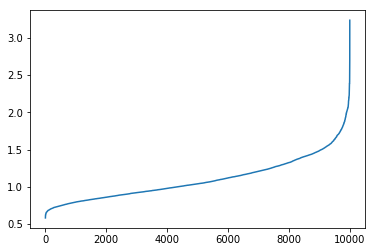

In [10]:
# Calculating the <eps> distance.
neigh_dist(fil_vec, 100)

** From the plot it is clear that the right valus of eps is found between 1.5 - 2.0, the middle value of 1.75 will be right value of eps. **

In [11]:
labeled = dbscan(fil_vec, chose_eps=True, eps_value=1.75)

The dimension of the data is: 100 and with choice of <eps>


In [12]:
print("The number of clusters are: {}".format(len(set(labeled)) - 1))

The number of clusters are: 1


** Finding the Noise reviews. **

In [13]:
print("The noise points are: \n")
for count, label in enumerate(labeled):
    
    if(label == -1):
        print("----------------")
        print("The index of the review is: {0} and the reivew is: \n\n{1}\n\n\n".format(count, df['Text'].loc[count]))

The noise points are: 

----------------
The index of the review is: 525 and the reivew is: 

My 2 older dogs love this product.  I also know that it is good for them.



----------------
The index of the review is: 760 and the reivew is: 

For all the saturated fat and sugar these bars just aren't good.  They don't satisfy a chocolate craving and the protein content isn't significant at 4g.<br /><br />I would not purchase again.



----------------
The index of the review is: 773 and the reivew is: 

All-in-all, the Herb Filled Salad Dressing Mix for Olive or Salad Oils is quite good, although I personally found the item to be better-used as an all-purpose seasoning. Mixed with extra-virgin olive oil, the dressing is flavorful, although you might need to add a bit more than the directions recommend. Personally, I used the product more effectively as a rub or marinade for chicken and pork. Either way, the results were delicious. As seasonings go, you could do far worse, and the value i

## TFIDF - W2V

In [14]:
tfw2v = np.load('tf-idf-w2v.npy',  mmap_mode='r+')

In [15]:
fil_df, fil_vec = sample_data(tfw2v, df, 100, random=True)

** DBSCAN **

** 1. Calculating the <font color='red'>eps</font> value as choice and running the  <font color='red'>DBSCAN</font> algorithm on the complete dataset.**

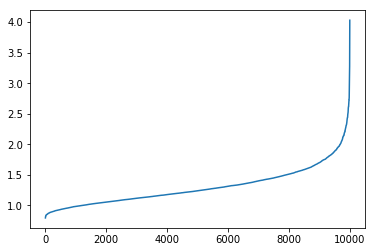

In [16]:
# Calculating the <eps> distance.
neigh_dist(fil_vec, 100)

** From the plot it is clear that the right valus of eps is found between 1.75 - 2.25, the middle value of 2 will be right value of eps. **

In [17]:
labeled = dbscan(fil_vec, chose_eps=True, eps_value=2)

The dimension of the data is: 100 and with choice of <eps>


In [18]:
print("The number of clusters are: {}".format(len(set(labeled)) - 1))

The number of clusters are: 1


** Finding the Noise reviews. **

In [19]:
print("The noise points are: \n")
for count, label in enumerate(labeled):
    
    if(label == -1):
        print("----------------")
        print("The index of the review is: {0} and the reivew is: \n\n{1}\n\n\n".format(count, df['Text'].loc[count]))

The noise points are: 

----------------
The index of the review is: 133 and the reivew is: 

I grabbed these up on a Friday sale, six bags for 6.99!<br /><br />What a bargain!<br /><br />Great for salads, cooking, baking, and toasting for snacks!<br /><br />Delighted here!



----------------
The index of the review is: 334 and the reivew is: 

I ordered 3 bags so I could get a good assortment.  WRONG All 3 bags were the same, sticked together like a brick.  No joke! it took 1 1/2 weeks to reach me.  Grandchildren were upset since they didn't get theirs.  They were too sticky and messy.  Spent almost $30 on this.  Will not order in the hot months again.  But my son loved them. LOL sticked together, sticky and all.  What can I say he loves Jelly Bellies anyway he can get them.  Unless it's butter popcorn and coffee flavorers. All in all I was disappointed in the quality of the goods when I received them.



----------------
The index of the review is: 1349 and the reivew is: 

My cats 

## Google AVG W2V

In [20]:
goo_avg_w2v = np.load('final-google-avg-w2v.npy', mmap_mode='r+')

In [21]:
fil_df, fil_vec = sample_data(goo_avg_w2v, df, 100, random=True)

** DBSCAN **

** 1. Calculating the <font color='red'>eps</font> value as choice and running the  <font color='red'>DBSCAN</font> algorithm on the complete dataset.**

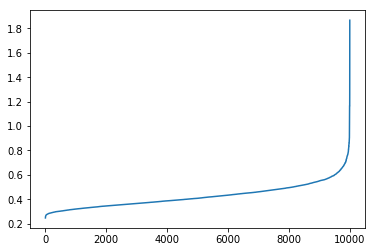

In [22]:
# Calculating the <eps> distance.
neigh_dist(fil_vec, 100)

** From the plot it is clear that the right valus of eps is found between 0.5 - 0.75, the middle value of 2 will be right value of eps. **

In [23]:
labeled = dbscan(fil_vec, chose_eps=True, eps_value=0.65)

The dimension of the data is: 600 and with choice of <eps>


In [24]:
print("The number of clusters are: {}".format(len(set(labeled)) - 1))

The number of clusters are: 1


** Finding the Noise reviews. **

In [25]:
print("The noise points are: \n")
for count, label in enumerate(labeled):
    
    if(label == -1):
        print("----------------")
        print("The index of the review is: {0} and the reivew is: \n\n{1}\n\n\n".format(count, df['Text'].loc[count]))

The noise points are: 

----------------
The index of the review is: 106 and the reivew is: 

This is a delicious product, but not my favorite in the Emerald nuts line.  It is very sweet compared to some of the others.



----------------
The index of the review is: 138 and the reivew is: 

Excellent coffee, dark roast flavor, brews fast and only have to make one or two cups at a time.



----------------
The index of the review is: 225 and the reivew is: 

I frist found these in Wa. state. was in Texas 4 months and could not find these at any pet or feed store so went to the net. They do not smell like other chews last a long time and digest well. My dog has never chocked on them like some of the others we have tried. He loves them.



----------------
The index of the review is: 299 and the reivew is: 

Took FOREVER to arrive and the case is way too many cookies to consume! Will stick to my local organic grocery next time. Once again, ordering food from Amazon has fallen far below ex

----------------
The index of the review is: 8187 and the reivew is: 

Maggie loved the bully sticks, but we could not tolerate the smell in the house. The pack we got smelled like rotting garbage after sitting in the sun for hours. We froze them to help with the smell, but once she starts eating them the odor permeates the room. After eating the bully sticks, we have to give her dental treats to get rid of her awful breath.



----------------
The index of the review is: 8554 and the reivew is: 

I ordered Arnott's Tim Tam Crush Honeycomb instead I got Arnott's Tim Tam Sweet Wishes what happened? Also, I had the samething on my order form saying I oredered Crush Honeycomb not professional at all.



----------------
The index of the review is: 8566 and the reivew is: 

Ordered this product for a candy dish I keep for my fellow employees at work. I like to have a mix of hard candies for them so they can choose for themselves. Cherryfield Candy sent this product very fast... very good r

## Google TFIDF - AVG W2V

In [26]:
goo_tfidf_w2v = np.load("final-google-tfidf-avg-w2v.npy", mmap_mode='r+')

In [27]:
fil_df, fil_vec = sample_data(goo_tfidf_w2v, df, 100, random=True)

** DBSCAN **

** 1. Calculating the <font color='red'>eps</font> value as choice and running the  <font color='red'>DBSCAN</font> algorithm on the complete dataset.**

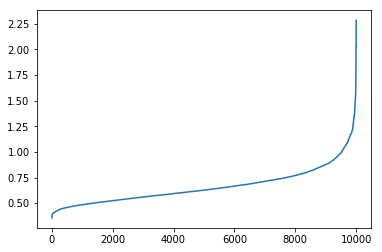

In [28]:
# Calculating the <eps> distance.
neigh_dist(fil_vec, 100)

** From the plot it is clear that the right valus of eps is found between 0.85 - 1.25, the middle value of 1 will be right value of eps. **

In [29]:
labeled = dbscan(fil_vec, chose_eps=True, eps_value=1)

The dimension of the data is: 600 and with choice of <eps>


In [30]:
print("The number of clusters are: {}".format(len(set(labeled)) - 1))

The number of clusters are: 1


** Finding the Noise reviews. **

In [31]:
print("The noise points are: \n")
for count, label in enumerate(labeled):
    
    if(label == -1):
        print("----------------")
        print("The index of the review is: {0} and the reivew is: \n\n{1}\n\n\n".format(count, df['Text'].loc[count]))

The noise points are: 

----------------
The index of the review is: 9 and the reivew is: 

The Senseo machine shipped with two 18-pod samples packs, light roast and medium roast.  Excited about my new machine, I brewed my first cups of coffee only to be disappointed, not by the machine itself (awesome!), but by the quality of the coffee.  The light roast was so-so, and the medium TERRIBLE.  I quickly ordered the dark to compare, and can now HIGHLY recommend the dark roast over the other two options.  The dark also works the best in espresso-like brewing mode, using two-pods with the 1-cup setting.  It's still not the best coffee out there, and I'm looking forward to comparing with the upcoming podhead.com pods.



----------------
The index of the review is: 60 and the reivew is: 

Do not bother to purchase these noodles. They are the worst thing I have ever tasted. They are like eating rubber bands. They should be on Fear Factor.



----------------
The index of the review is: 180 an

The index of the review is: 8961 and the reivew is: 

The individually wrapped mints  had melted.  This is a nonreturnable product.  To salvage the tub of treats it was necessary to scrape the patty from the wrapper and even then most of the chocolate was left as it had adhered to the wrapper.  I will order the larger patties in the future.



----------------
The index of the review is: 9002 and the reivew is: 

Roasted taste isn't as strong as I like. Color is dark brown, but the taste is still too light for my liking. Doesn't taste like green tea. Strong "woody" taste. Kind of pricey, too. I won't buy it again.



----------------
The index of the review is: 9131 and the reivew is: 

I have super thick, naturally wavy hair that I dye a lot.  It frizzes a lot.  The problem I have with products is always finding that balance between getting the frizz to go away or when it does my hair looks to greasy, blech.  I usually end up just not using much or flat ironing and using higher end pr

# Deep Learning

## Truncated SVD 

In [18]:
def compute_coo_matrix(df, top_words):
    
    dummy_values = np.zeros([len(top_words), len(top_words)])
    coo_matrix = pd.DataFrame(dummy_values, columns=top_words, index=top_words)
    
    # Iterating on each of the review
    for review in tqdm(df['Text'].values):
    # Splitting each review to form a list of words.
        review = review.split()
    # This list stores all the words of the review that are present in the top_words.
        present = []
    
    # Checking the word is present in the top_words.
        review_index = 0
        for word in review:
            if(word in top_words):
            # Appending each (word, index) to the "present" list.
                present.append((word, review_index))
            review_index = review_index + 1
   
    # print(present)    
        for context_word in present:
        # Setting the window range for the context word.
            win_range = (context_word[1] - 5, context_word[1] + 5)
        # Iterating on all the words that are present in the "present" list
            for find_word in present:
            # checking wheather the word is in the window range and the "find_word" should not be exactly equal to "context_word".
                if((find_word[1] > win_range[0]) and (find_word[1] < win_range[1]) and (find_word[1] != context_word[1])):
                # Incrementing the coo_matrix at the given position.
                    coo_matrix[context_word[0]][find_word[0]] = coo_matrix[context_word[0]][find_word[0]] + 1
    
    #Setting the index and the "present" array to default.    
        review_index = 0
        present = []
        
    return coo_matrix

In [38]:
from sklearn.decomposition import TruncatedSVD

In [39]:
%matplotlib inline

In [95]:
def truncated_svd(coo_matrix, n_components):
    
    svd = TruncatedSVD(n_components=n_components)
    svd_data = svd.fit_transform(coo_matrix)
    percentage_variance_explained = svd.explained_variance_ / sum(svd.explained_variance_)
    cum_var_explained = np.cumsum(percentage_variance_explained)
    
    plt.clf()
    plt.plot(cum_var_explained, linewidth=2)
    plt.axis('tight')
    plt.grid()
    plt.title("Explained Variance Chart")
    plt.xlabel("Number of components")
    plt.ylabel("Cummulative Explained Varaince")
    plt.show()
    return svd_data

In [41]:
from sklearn.cluster import KMeans

In [131]:
def word_vec_kmeans(vec, n_clusters = 50):
    op_kmeans = KMeans(n_clusters=n_clusters)
    op_kmeans.fit(vec)
    vec_labels = op_kmeans.predict(vec)
    
    return vec_labels

In [144]:
def get_reviews(words, word_labels):
    unique_labels = set(word_labels)
    sel_two_clus = np.random.randint(low=min(unique_labels), high=max(unique_labels), size=2)
    word_label_df = pd.DataFrame({'word':words, 'labels':word_labels})
    for cluster in sel_two_clus:
        print("For cluster: {}".format(cluster))
        print(word_label_df[word_label_df['labels'] == cluster]['word'].values)
    return

In [11]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

**Computing TF-IDF and extracting the Top words.**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:

tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(df['Text'].values)


In [14]:
print("The shape of the Tf-Idf vectors: {}".format(final_tf_idf.get_shape()))
features = tf_idf_vect.get_feature_names()

The shape of the Tf-Idf vectors: (364171, 115281)


## For Top 2000 TF-IDF Words. 

In [15]:
top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,2000)
top_words = top_tfidf['feature'].values.tolist()

In [19]:
coo_matrix = compute_coo_matrix(df, top_words)

100%|███████████████████████████████████████| 364171/364171 [46:47<00:00, 129.73it/s]


In [23]:
coo_matrix.to_csv('coo_matrix_2000.csv', index=False)

In [51]:
coo_matrix = pd.read_csv('coo_matrix_2000.csv', encoding='cp1252')

** Applying TruncatedSVD. **

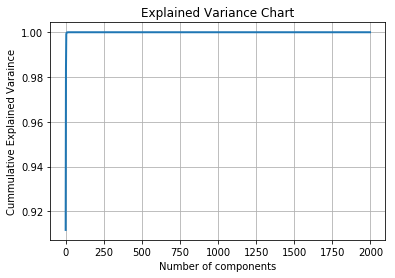

In [164]:
word_vectors = truncated_svd(coo_matrix,n_components=1999)

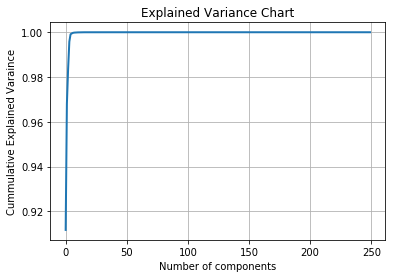

In [165]:
word_vectors = truncated_svd(coo_matrix,n_components=250)

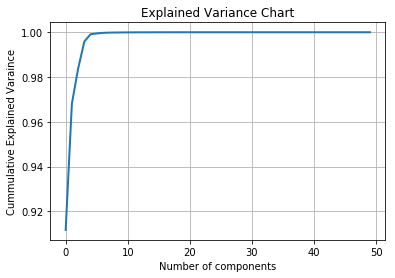

In [166]:
word_vectors = truncated_svd(coo_matrix,n_components=50)

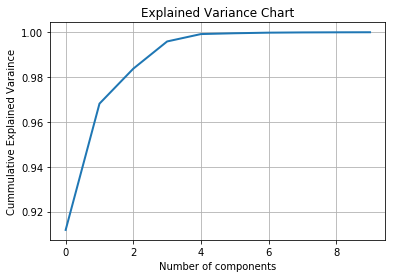

In [167]:
word_vectors = truncated_svd(coo_matrix,n_components=10)

** The idle number of components for SVD is 4, that captures the 99% of the variance in the data. **

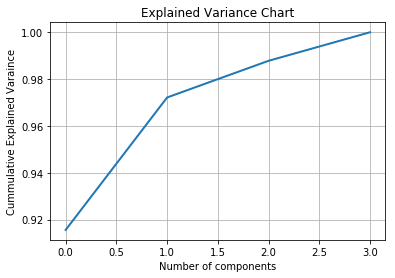

(2000, 4)

In [169]:
word_vectors = truncated_svd(coo_matrix,n_components=4)
word_vectors.shape

** Applying K-Means with number of clusters = 50. **

In [170]:
word_labels = word_vec_kmeans(word_vectors)

In [171]:
top_words = list(coo_matrix.columns)

** Words belonging for randomly selected two clusters. **

In [183]:
get_reviews(top_words, word_labels)

For cluster: 26
['dog']
For cluster: 43
['dozen' 'dozens' 'dollop' 'dose']


**Observations:**

* It appears to be the cluster 43 has all the words related to the quantity like dozen, dozens and dose. 


## For Top 5000 TF-IDF Words. 

In [184]:
top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,5000)
top_words = top_tfidf['feature'].values.tolist()

In [26]:
len(top_words)

5000

In [27]:
coo_matrix = compute_coo_matrix(final_df, top_words)

100%|██████████████████████████████████████| 364171/364171 [1:35:32<00:00, 63.52it/s]


In [28]:
coo_matrix.to_csv('coo_matrix_5000.csv', index=False)

In [185]:
coo_matrix = pd.read_csv('coo_matrix_5000.csv', encoding='cp1252')

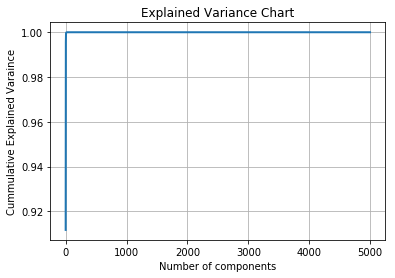

In [187]:
word_vectors = truncated_svd(coo_matrix,n_components=4999)

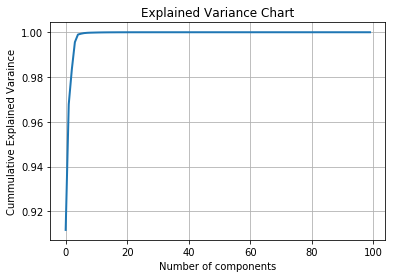

In [188]:
word_vectors = truncated_svd(coo_matrix,n_components=100)

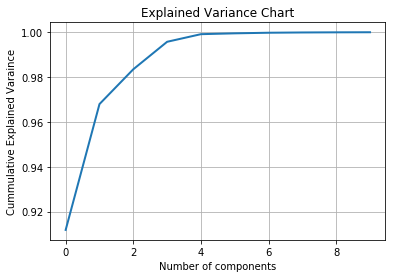

In [189]:
word_vectors = truncated_svd(coo_matrix,n_components=10)

** The idle number of components for SVD is 4, that captures the 99% of the variance in the data. **

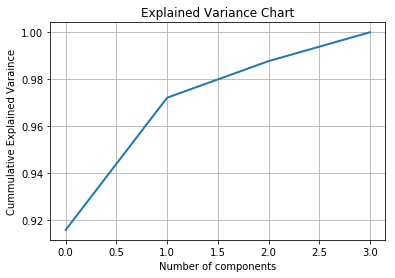

(5000, 4)

In [190]:
word_vectors = truncated_svd(coo_matrix,n_components=4)
word_vectors.shape

** Applying K-Means with number of clusters = 50. **

In [191]:
word_labels = word_vec_kmeans(word_vectors)

In [192]:
top_words = list(coo_matrix.columns)

** Words belonging for randomly selected two clusters. **

In [198]:
get_reviews(top_words, word_labels)

For cluster: 38
['down']
For cluster: 47
['distinctive' 'distinct' 'doesnt' 'dislike' 'disease' 'disgusting'
 'dissolves' 'drawback' 'dressings' 'dozen' 'dozens' 'drinkers' 'driving'
 'drizzle' 'dose' 'developed' 'determine' 'diarrhea' 'diaper' 'diabetes'
 'depth' 'dense' 'desire' 'desired' 'designed' 'dirt' 'direct' 'dipping'
 'dirty' 'discontinued' 'disappeared' 'disappointing' 'disappointment'
 'dietary' 'diced' 'die' 'died' 'dilute' 'difficulty' 'dig' 'digest'
 'digestion' 'entirely' 'ensure' 'equally' 'environment' 'encourage'
 'everywhere']


**Observations:**

* It appears to be the cluster 49 has all the words realated to the negativity words like dislike, disgusting, disappointing drawback, die and there are other words related to quatity.

** For Top 10000 TF-IDF Words. **

In [29]:
top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,10000)
top_words = top_tfidf['feature'].values.tolist()

In [30]:
coo_matrix = compute_coo_matrix(df, top_words)

100%|██████████████████████████████████████| 364171/364171 [4:04:55<00:00, 24.78it/s]


In [31]:
coo_matrix.to_csv('coo_matrix_10000.csv', index=False)

In [220]:
coo_matrix = pd.read_csv('coo_matrix_10000.csv', encoding='cp1252')

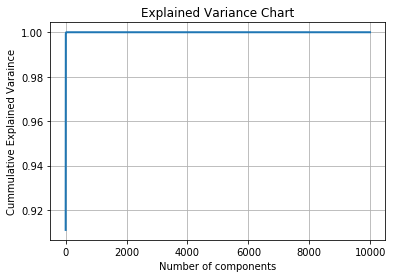

In [222]:
word_vectors = truncated_svd(coo_matrix,n_components=9999)

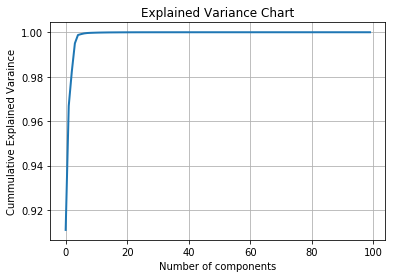

In [223]:
word_vectors = truncated_svd(coo_matrix,n_components=100)

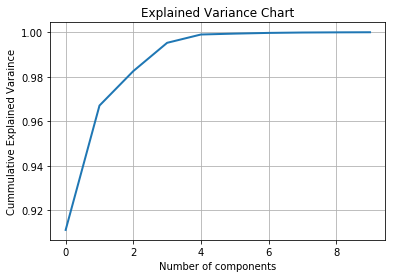

In [224]:
word_vectors = truncated_svd(coo_matrix,n_components=10)

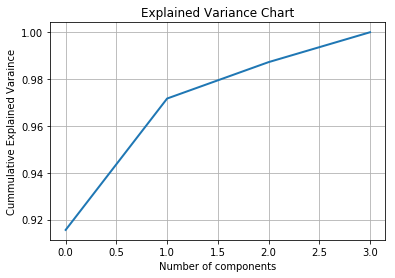

In [225]:
word_vectors = truncated_svd(coo_matrix,n_components=4)

In [226]:
word_labels = word_vec_kmeans(word_vectors)

In [227]:
top_words = list(coo_matrix.columns)

In [260]:
get_reviews(top_words, word_labels)

For cluster: 24
['movie' 'watching' 'distinct' 'doesnt' 'doctor' 'disease' 'disgusting'
 'dissolve' 'dissolves' 'drawer' 'dozen' 'dropped' 'drinker' 'drip'
 'dollar' 'dollars' 'downside' 'dose' 'developed' 'diarrhea' 'diaper'
 'diabetic' 'depending' 'depth' 'dented' 'dense' 'dental' 'desired' 'desk'
 'designed' 'dessert' 'described' 'dirt' 'direct' 'dipping' 'dip'
 'discontinued' 'discount' 'discover' 'dietary' 'didnt' 'die' 'digest'
 'digestive' 'ensure' 'equivalent' 'equal' 'equally' 'enhance' 'enhances'
 'enjoyable' 'eventually' 'everywhere' 'everyday' 'essential' 'easiest'
 'eater' 'earlier' 'economical' 'edges' 'dumped' 'duck' 'dust' 'email'
 'emailed' 'edible' 'effective' 'effort' 'eight' 'constantly' 'contact'
 'consume' 'consumed' 'consumer' 'consuming' 'considered' 'consistently'
 'consistent' 'concentrate' 'concept' 'concern' 'compliments' 'corner'
 'continued' 'continues' 'containing' 'cooks' 'closer' 'closed' 'coated'
 'coats' 'classic' 'cleaning' 'citrus' 'compliment' 'com

** Observations: **

* It is observed that the cluster 24 has words related to the quantity, measure of substance.

## Recurrent Neural Network

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)


Using TensorFlow backend.


** Load Data Frame.**

In [4]:
df = pd.read_csv('drive/applied_ai/ARA/final_df.csv', encoding='cp1252')

In [6]:
Texts = df['Text'].values

** Fit and transform the count vectorizer for the reviews. **

In [7]:
top_words = 5000 # Selecting the top rank words from the whole text corpus
max_review_length = 600 # The output length of the vector after padding the each vector.
embedding_vecor_output_length = 32 # The output dimensions of the embedding layer of each vector.

In [8]:
def word_count(str):
    counts = dict()
    
    for sentence in str:
        
        words = sentence.split()
        
        for word in words:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1

    return counts

In [9]:
def get_text_vectors(corpus, upto_rank= None):
    name_count = word_count(corpus)
    name_count_df = pd.DataFrame(name_count, index=['Count'])
    name_count_df.sort_values(['Count'], axis=1, ascending=False, inplace=True)
    ranked_name_count = name_count_df.rank(axis=1,method='dense', ascending=False)
    unique_names = name_count_df.columns
    unique_names_rank = ranked_name_count.values.tolist()[0]
    unique_names_rank = [i for i in unique_names_rank if i < upto_rank]
    unique_name_rank_dic = {}
    
    for i in zip(unique_names, unique_names_rank):
        unique_name_rank_dic[i[0]] = i[1] 
    
    Text_vectors = []

    for i in Texts:
        temp = []
        for j in i.split():
            if(unique_name_rank_dic.get(j)!=None):
            
                temp.append(unique_name_rank_dic.get(j))
        Text_vectors.append(temp)
        temp = []
        
    return Text_vectors

** Get the vectors of the reviews uptil the specified Rank. **

In [10]:
X = get_text_vectors(Texts, upto_rank=5000)
Y = (df['score_labels'])

** As RNN preserve the sequence information and dependent of the sequence of data. There is no need of time based train test split. **

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [13]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(6700, 600)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   

In [14]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_output_length, input_length=max_review_length))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               109800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 269,951
Trainable params: 269,951
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
X_train.shape

(6700, 600)

In [16]:
y_train.shape

(6700,)

In [17]:
model.fit(X_train, y_train, nb_epoch=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
6700/6700 [==============================] - 148s 22ms/step - loss: 0.6441 - acc: 0.6261
Epoch 2/10
6700/6700 [==============================] - 147s 22ms/step - loss: 0.4888 - acc: 0.7643
Epoch 3/10
6700/6700 [==============================] - 147s 22ms/step - loss: 0.4424 - acc: 0.7937
Epoch 4/10
6208/6700 [==========================>...] - ETA: 10s - loss: 0.4199 - acc: 0.81126700/6700 [==============================] - 147s 22ms/step - loss: 0.4245 - acc: 0.8079
Epoch 5/10
6700/6700 [==============================] - 148s 22ms/step - loss: 0.4095 - acc: 0.8119
Epoch 6/10
6700/6700 [==============================] - 148s 22ms/step - loss: 0.3939 - acc: 0.8210
Epoch 7/10
6700/6700 [==============================] - 148s 22ms/step - loss: 0.3865 - acc: 0.8270
Epoch 8/10
1216/6700 [====>.........................] - ETA: 1:59 - loss: 0.3497 - acc: 0.85616700/6700 [==============================] - 147s 22ms/step - loss: 0.3798 - acc: 0.8306
Epoch 9/10
6700/6700 [=============

                            END